In [1]:
import ee
ee.Authenticate()
ee.Initialize


Successfully saved authorization token.


<function ee.Initialize(credentials: Optional[Any] = 'persistent', url: Optional[str] = None, cloud_api_key: Optional[str] = None, http_transport: Optional[Any] = None, project: Union[int, str, NoneType] = None) -> None>

In [ ]:
import ee
import numpy as np
import os
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from datetime import datetime, timedelta, timezone
import geopandas as gpd
from shapely.geometry import mapping
import boto3
import io

# 📦 Connexion au bucket S3
s3 = boto3.client("s3",endpoint_url = 'https://'+'minio.lab.sspcloud.fr',
                  aws_access_key_id= 'NFL60EFJUDDV2NNHLZ8A', 
                  aws_secret_access_key= 'SEfeM+G3Ng0HJi6vb6CnW67wLzUu48wRpPho63Gb', 
                  aws_session_token = 'eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJhY2Nlc3NLZXkiOiJORkw2MEVGSlVERFYyTk5ITFo4QSIsImFsbG93ZWQtb3JpZ2lucyI6WyIqIl0sImF1ZCI6WyJtaW5pby1kYXRhbm9kZSIsIm9ueXhpYSIsImFjY291bnQiXSwiYXV0aF90aW1lIjoxNzUzMDgyMzE3LCJhenAiOiJvbnl4aWEiLCJlbWFpbCI6ImFudG9pbmUubGVzYXV2YWdlQGFncmljdWx0dXJlLmdvdXYuZnIiLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwiZXhwIjoxNzUzNjkzOTAxLCJmYW1pbHlfbmFtZSI6IkxFU0FVVkFHRSIsImdpdmVuX25hbWUiOiJBbnRvaW5lIiwiZ3JvdXBzIjpbIlVTRVJfT05ZWElBIl0sImlhdCI6MTc1MzA4OTEwMCwiaXNzIjoiaHR0cHM6Ly9hdXRoLmxhYi5zc3BjbG91ZC5mci9hdXRoL3JlYWxtcy9zc3BjbG91ZCIsImp0aSI6Im9ucnRydDoyMjIwMzkxOC0wNDc5LTQxNDMtYjZjNC02MzI2NTI4ODYwMTAiLCJsb2NhbGUiOiJmciIsIm5hbWUiOiJBbnRvaW5lIExFU0FVVkFHRSIsInBvbGljeSI6InN0c29ubHkiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJhbnRvaW5lbGVzYXV2YWdlIiwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iLCJkZWZhdWx0LXJvbGVzLXNzcGNsb3VkIl19LCJyZXNvdXJjZV9hY2Nlc3MiOnsiYWNjb3VudCI6eyJyb2xlcyI6WyJtYW5hZ2UtYWNjb3VudCIsIm1hbmFnZS1hY2NvdW50LWxpbmtzIiwidmlldy1wcm9maWxlIl19fSwicm9sZXMiOlsib2ZmbGluZV9hY2Nlc3MiLCJ1bWFfYXV0aG9yaXphdGlvbiIsImRlZmF1bHQtcm9sZXMtc3NwY2xvdWQiXSwic2NvcGUiOiJvcGVuaWQgcHJvZmlsZSBncm91cHMgZW1haWwiLCJzaWQiOiIyNmMwNWExOC1lZTYyLTRlYTgtYjU4NC1jODMxZjFiOWU3NDciLCJzdWIiOiJlOWY4NjIyYy01MzQ2LTRjOGUtOWZmYi1jY2MwMzZjY2ZjZjciLCJ0eXAiOiJCZWFyZXIifQ.x-blmyoysU-BHK_dyWyBwWlB3_I27wtyO-vdEyPSLKVibm_lF6BwunlvzRzhod1mD9LUFht538xnyrr1Nyi0KQ')
BUCKET_NAME = "antoinelesauvage"  # change ici
S3_PREFIX = "vergers-france/data_2018"
 
def s3_file_exists(bucket, key):
    try:
        s3.head_object(Bucket=bucket, Key=key)
        return True
    except s3.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            return False
        else:
            raise
# Paramètres
BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']  # Limiter le nombre de bandes
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
SCALE = 10  # Ajuster l'échelle pour réduire la résolution
#EXPORT_DIR = "/home/onyxia/work/data/patches_2018"
MAX_WORKERS = 6

# Initialiser Earth Engine
ee.Initialize()

# Charger la grille
grid = gpd.read_file("grid_indre_loire.geojson")
tiles = [ee.Geometry(mapping["geometry"]) for mapping in grid.iterfeatures()]
def download_tile(tile_id):
    tile = tiles[tile_id]  # ✅ défini ici
    collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
        .filterDate(START_DATE, END_DATE) \
        .filterBounds(tile) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .select(BANDS)

    try:
        dates = collection.aggregate_array("system:time_start").getInfo()
        dates = sorted(set(datetime.fromtimestamp(t / 1000, tz=timezone.utc).strftime('%Y%m%d') for t in dates))
    except Exception as e:
        print(f"❌ Erreur d'accès à la collection pour tile {tile_id} : {e}")
        return


    for date in dates:
        filename_s3 = f"{tile_id}_{date}.npy"
        key = f"{S3_PREFIX}/{filename_s3}"
        if s3_file_exists(BUCKET_NAME, key):
            print(f"⏭️  Déjà présent sur S3 : {filename_s3}")
            continue

        try:
            date_obj = datetime.strptime(date, "%Y%m%d")
            start = (date_obj - timedelta(days=2)).strftime("%Y-%m-%d")
            end = (date_obj + timedelta(days=2)).strftime("%Y-%m-%d")
            image = collection.filterDate(start, end).median()

            size_info = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=tile,  # ✅ pas "region"
                scale=10,
                maxPixels=1e8
            ).getInfo()
            #print(f"Informations de réduction pour tile {tile_id} et date {date}: {size_info}")
            # ✅ Vérification que les bandes ne sont pas toutes vides
            if not size_info or all(v is None or v == 0 for v in size_info.values()):
                print(f"⛔ Patch vide pour tile {tile_id}, date {date}")
                continue
            patch = image.clip(tile)
            #patch = image.clip(tile).resample('bicubic').reproject(crs='EPSG:4326', scale=SCALE)
            url = patch.getDownloadURL({
                'scale': SCALE,
                'region': tile,  # ✅ cohérent avec le reste
                'format': 'NPY'
            })

            r = requests.get(url)
            if r.status_code == 200:
                    s3.upload_fileobj(
                    io.BytesIO(r.content),
                    BUCKET_NAME,
                    f"{S3_PREFIX}/{filename_s3}"
                    )
            else:
                print(f"Requête échouée pour {tile_id} {date} avec le code: {r.status_code}")

        except Exception as e:
            print(f"⚠️ {date} failed for tile {tile_id}: {e}")

    print(f"✅ Tuile {tile_id} terminée.")

# Téléchargement parallèle
with ThreadPool
Executor(max_workers=MAX_WORKERS) as executor:
    futures = [executor.submit(download_tile, i) for i in range(len(tiles))] #len(tiles)
    for future in tqdm(as_completed(futures), total=len(futures), desc="Tuiles traitées"):
        pass

Tuiles traitées:   0%|          | 0/1038 [00:00<?, ?it/s]

⏭️  Déjà présent sur S3 : 2_20180208.npy
⏭️  Déjà présent sur S3 : 5_20180208.npy
⏭️  Déjà présent sur S3 : 4_20180208.npy
⏭️  Déjà présent sur S3 : 2_20180320.npy
⏭️  Déjà présent sur S3 : 0_20180208.npy
⏭️  Déjà présent sur S3 : 3_20180208.npy
⏭️  Déjà présent sur S3 : 4_20180320.npy
⏭️  Déjà présent sur S3 : 2_20180419.npy
⏭️  Déjà présent sur S3 : 5_20180320.npy
⏭️  Déjà présent sur S3 : 0_20180320.npy
⏭️  Déjà présent sur S3 : 3_20180320.npy
⏭️  Déjà présent sur S3 : 1_20180208.npy
⏭️  Déjà présent sur S3 : 5_20180419.npy
⏭️  Déjà présent sur S3 : 2_20180424.npy
⏭️  Déjà présent sur S3 : 4_20180419.npy
⏭️  Déjà présent sur S3 : 0_20180419.npy
⏭️  Déjà présent sur S3 : 3_20180419.npy
⏭️  Déjà présent sur S3 : 1_20180320.npy
⏭️  Déjà présent sur S3 : 4_20180424.npy
⏭️  Déjà présent sur S3 : 0_20180424.npy
⏭️  Déjà présent sur S3 : 0_20180504.npy
⏭️  Déjà présent sur S3 : 3_20180424.npy
⏭️  Déjà présent sur S3 : 2_20180504.npy
⏭️  Déjà présent sur S3 : 0_20180519.npy
⏭️  Déjà présent

Tuiles traitées:   0%|          | 1/1038 [00:01<22:29,  1.30s/it]

⏭️  Déjà présent sur S3 : 3_20180901.npy
⏭️  Déjà présent sur S3 : 4_20180822.npy
⏭️  Déjà présent sur S3 : 1_20180723.npy
⏭️  Déjà présent sur S3 : 2_20180911.npy
⏭️  Déjà présent sur S3 : 0_20181130.npy
⏭️  Déjà présent sur S3 : 5_20180802.npy
⏭️  Déjà présent sur S3 : 4_20180901.npy
⏭️  Déjà présent sur S3 : 3_20180911.npy
⏭️  Déjà présent sur S3 : 2_20180926.npy
⏭️  Déjà présent sur S3 : 0_20181210.npy
⏭️  Déjà présent sur S3 : 1_20180802.npy
⏭️  Déjà présent sur S3 : 4_20180911.npy
⏭️  Déjà présent sur S3 : 5_20180822.npy
⏭️  Déjà présent sur S3 : 3_20180926.npy
⏭️  Déjà présent sur S3 : 2_20181021.npy
⏭️  Déjà présent sur S3 : 1_20180822.npy
⏭️  Déjà présent sur S3 : 0_20181220.npy
⏭️  Déjà présent sur S3 : 4_20180926.npy
⏭️  Déjà présent sur S3 : 5_20180901.npy
⏭️  Déjà présent sur S3 : 1_20180901.npy
⏭️  Déjà présent sur S3 : 3_20181021.npy
⏭️  Déjà présent sur S3 : 2_20181130.npy
⏭️  Déjà présent sur S3 : 0_20181225.npy
✅ Tuile 0 terminée.
⏭️  Déjà présent sur S3 : 5_20180911.

Tuiles traitées:   0%|          | 5/1038 [00:01<03:26,  5.00it/s]

⏭️  Déjà présent sur S3 : 3_20181225.npy
✅ Tuile 3 terminée.
⏭️  Déjà présent sur S3 : 4_20181220.npy
⏭️  Déjà présent sur S3 : 1_20181130.npy
⏭️  Déjà présent sur S3 : 5_20181130.npy
⏭️  Déjà présent sur S3 : 4_20181225.npy
✅ Tuile 4 terminée.
⏭️  Déjà présent sur S3 : 1_20181210.npy
⏭️  Déjà présent sur S3 : 5_20181210.npy
⏭️  Déjà présent sur S3 : 1_20181220.npy
⏭️  Déjà présent sur S3 : 5_20181220.npy
⏭️  Déjà présent sur S3 : 1_20181225.npy
✅ Tuile 1 terminée.
⏭️  Déjà présent sur S3 : 5_20181225.npy
✅ Tuile 5 terminée.
⏭️  Déjà présent sur S3 : 6_20180208.npy
⏭️  Déjà présent sur S3 : 6_20180320.npy
⏭️  Déjà présent sur S3 : 7_20180208.npy
⏭️  Déjà présent sur S3 : 6_20180419.npy
⏭️  Déjà présent sur S3 : 6_20180424.npy
⏭️  Déjà présent sur S3 : 7_20180320.npy
⏭️  Déjà présent sur S3 : 6_20180504.npy
⏭️  Déjà présent sur S3 : 7_20180419.npy
⏭️  Déjà présent sur S3 : 7_20180424.npy
⏭️  Déjà présent sur S3 : 6_20180519.npy
⏭️  Déjà présent sur S3 : 9_20180208.npy
⏭️  Déjà présent s

Tuiles traitées:   1%|          | 7/1038 [00:02<05:20,  3.22it/s]

⏭️  Déjà présent sur S3 : 6_20181210.npy
⏭️  Déjà présent sur S3 : 11_20180703.npy
⏭️  Déjà présent sur S3 : 7_20181021.npy
⏭️  Déjà présent sur S3 : 6_20181220.npy
⏭️  Déjà présent sur S3 : 9_20180911.npy
⏭️  Déjà présent sur S3 : 8_20180822.npy
⏭️  Déjà présent sur S3 : 11_20180708.npy
⏭️  Déjà présent sur S3 : 9_20180926.npy
⏭️  Déjà présent sur S3 : 10_20180708.npy
⏭️  Déjà présent sur S3 : 11_20180723.npy
⏭️  Déjà présent sur S3 : 7_20181130.npy
⏭️  Déjà présent sur S3 : 10_20180723.npy
⏭️  Déjà présent sur S3 : 7_20181210.npy
⏭️  Déjà présent sur S3 : 6_20181225.npy
✅ Tuile 6 terminée.
⏭️  Déjà présent sur S3 : 7_20181220.npy
⏭️  Déjà présent sur S3 : 9_20181021.npy
⏭️  Déjà présent sur S3 : 8_20180901.npy
⏭️  Déjà présent sur S3 : 10_20180802.npy
⏭️  Déjà présent sur S3 : 11_20180802.npy
⏭️  Déjà présent sur S3 : 9_20181130.npy
⏭️  Déjà présent sur S3 : 7_20181225.npy
✅ Tuile 7 terminée.
⏭️  Déjà présent sur S3 : 10_20180822.npy


Tuiles traitées:   1%|          | 9/1038 [00:02<04:15,  4.03it/s]

⏭️  Déjà présent sur S3 : 9_20181210.npy
⏭️  Déjà présent sur S3 : 11_20180822.npy
⏭️  Déjà présent sur S3 : 8_20180911.npy
⏭️  Déjà présent sur S3 : 9_20181220.npy
⏭️  Déjà présent sur S3 : 10_20180901.npy
⏭️  Déjà présent sur S3 : 11_20180901.npy
⏭️  Déjà présent sur S3 : 9_20181225.npy
✅ Tuile 9 terminée.
⏭️  Déjà présent sur S3 : 11_20180911.npy
⏭️  Déjà présent sur S3 : 10_20180911.npy
⏭️  Déjà présent sur S3 : 11_20180926.npy
⏭️  Déjà présent sur S3 : 10_20180926.npy
⏭️  Déjà présent sur S3 : 12_20180208.npy
⏭️  Déjà présent sur S3 : 11_20181021.npy
⏭️  Déjà présent sur S3 : 12_20180320.npy
⏭️  Déjà présent sur S3 : 10_20181021.npy
⏭️  Déjà présent sur S3 : 12_20180419.npy
⏭️  Déjà présent sur S3 : 11_20181130.npy
⏭️  Déjà présent sur S3 : 13_20180208.npy
⏭️  Déjà présent sur S3 : 11_20181210.npy
⏭️  Déjà présent sur S3 : 12_20180424.npy
⏭️  Déjà présent sur S3 : 13_20180320.npy


Tuiles traitées:   1%|          | 10/1038 [00:03<04:50,  3.54it/s]

⏭️  Déjà présent sur S3 : 10_20181130.npy
⏭️  Déjà présent sur S3 : 11_20181220.npy
⏭️  Déjà présent sur S3 : 12_20180504.npy
⏭️  Déjà présent sur S3 : 13_20180419.npy
⏭️  Déjà présent sur S3 : 10_20181210.npy
⏭️  Déjà présent sur S3 : 12_20180519.npy
⏭️  Déjà présent sur S3 : 10_20181220.npy
⏭️  Déjà présent sur S3 : 13_20180424.npy
⏭️  Déjà présent sur S3 : 12_20180623.npy
⏭️  Déjà présent sur S3 : 13_20180504.npy
⏭️  Déjà présent sur S3 : 13_20180519.npy
⏭️  Déjà présent sur S3 : 10_20181225.npy
✅ Tuile 10 terminée.
⏭️  Déjà présent sur S3 : 13_20180623.npy
⏭️  Déjà présent sur S3 : 14_20180208.npy⏭️  Déjà présent sur S3 : 11_20181225.npy
✅ Tuile 11 terminée.
⏭️  Déjà présent sur S3 : 12_20180628.npy

⏭️  Déjà présent sur S3 : 13_20180628.npy
⏭️  Déjà présent sur S3 : 14_20180320.npy
⏭️  Déjà présent sur S3 : 12_20180703.npy
⏭️  Déjà présent sur S3 : 13_20180703.npy
⏭️  Déjà présent sur S3 : 14_20180419.npy
⏭️  Déjà présent sur S3 : 14_20180424.npy
⏭️  Déjà présent sur S3 : 13_20180

Tuiles traitées:   1%|          | 12/1038 [00:03<04:50,  3.53it/s]

⏭️  Déjà présent sur S3 : 14_20180822.npy
⏭️  Déjà présent sur S3 : 15_20180419.npy
⏭️  Déjà présent sur S3 : 14_20180901.npy
⏭️  Déjà présent sur S3 : 13_20181210.npy
⏭️  Déjà présent sur S3 : 15_20180424.npy
⏭️  Déjà présent sur S3 : 14_20180911.npy
⏭️  Déjà présent sur S3 : 13_20181220.npy
⏭️  Déjà présent sur S3 : 14_20180926.npy
⏭️  Déjà présent sur S3 : 12_20181225.npy
✅ Tuile 12 terminée.
⏭️  Déjà présent sur S3 : 16_20180419.npy
⏭️  Déjà présent sur S3 : 13_20181225.npy
✅ Tuile 13 terminée.
⏭️  Déjà présent sur S3 : 15_20180504.npy
⏭️  Déjà présent sur S3 : 16_20180424.npy
⏭️  Déjà présent sur S3 : 14_20181021.npy
⏭️  Déjà présent sur S3 : 16_20180504.npy
⏭️  Déjà présent sur S3 : 15_20180519.npy
⏭️  Déjà présent sur S3 : 14_20181130.npy
⏭️  Déjà présent sur S3 : 16_20180519.npy
⏭️  Déjà présent sur S3 : 15_20180623.npy
⏭️  Déjà présent sur S3 : 14_20181210.npy


Tuiles traitées:   1%|▏         | 14/1038 [00:03<03:33,  4.79it/s]

⏭️  Déjà présent sur S3 : 15_20180628.npy
⏭️  Déjà présent sur S3 : 14_20181220.npy
⏭️  Déjà présent sur S3 : 16_20180623.npy
⏭️  Déjà présent sur S3 : 15_20180703.npy
⏭️  Déjà présent sur S3 : 14_20181225.npy
✅ Tuile 14 terminée.
⏭️  Déjà présent sur S3 : 16_20180628.npy
⏭️  Déjà présent sur S3 : 15_20180708.npy
⏭️  Déjà présent sur S3 : 16_20180703.npy
⏭️  Déjà présent sur S3 : 15_20180723.npy
⏭️  Déjà présent sur S3 : 16_20180708.npy
⏭️  Déjà présent sur S3 : 15_20180802.npy
⏭️  Déjà présent sur S3 : 16_20180723.npy
⏭️  Déjà présent sur S3 : 16_20180802.npy
⏭️  Déjà présent sur S3 : 15_20180822.npy
⏭️  Déjà présent sur S3 : 18_20180208.npy
⏭️  Déjà présent sur S3 : 15_20180901.npy
⏭️  Déjà présent sur S3 : 18_20180320.npy
⏭️  Déjà présent sur S3 : 16_20180822.npy
⏭️  Déjà présent sur S3 : 17_20180208.npy
⏭️  Déjà présent sur S3 : 15_20180911.npy
⏭️  Déjà présent sur S3 : 15_20180926.npy
⏭️  Déjà présent sur S3 : 16_20180901.npy
⏭️  Déjà présent sur S3 : 18_20180419.npy
⏭️  Déjà prés

Tuiles traitées:   1%|▏         | 15/1038 [00:04<04:41,  3.64it/s]

⏭️  Déjà présent sur S3 : 17_20180424.npy
⏭️  Déjà présent sur S3 : 18_20180504.npy
⏭️  Déjà présent sur S3 : 19_20180419.npy
⏭️  Déjà présent sur S3 : 15_20181210.npy
⏭️  Déjà présent sur S3 : 17_20180504.npy
⏭️  Déjà présent sur S3 : 16_20181021.npy
⏭️  Déjà présent sur S3 : 18_20180519.npy
⏭️  Déjà présent sur S3 : 15_20181220.npy
⏭️  Déjà présent sur S3 : 16_20181130.npy
⏭️  Déjà présent sur S3 : 18_20180623.npy
⏭️  Déjà présent sur S3 : 19_20180424.npy
⏭️  Déjà présent sur S3 : 17_20180519.npy
⏭️  Déjà présent sur S3 : 16_20181210.npy
⏭️  Déjà présent sur S3 : 15_20181225.npy
✅ Tuile 15 terminée.
⏭️  Déjà présent sur S3 : 18_20180628.npy
⏭️  Déjà présent sur S3 : 16_20181220.npy
⏭️  Déjà présent sur S3 : 19_20180504.npy
⏭️  Déjà présent sur S3 : 17_20180623.npy
⏭️  Déjà présent sur S3 : 18_20180703.npy
⏭️  Déjà présent sur S3 : 19_20180519.npy
⏭️  Déjà présent sur S3 : 16_20181225.npy⏭️  Déjà présent sur S3 : 17_20180628.npy

✅ Tuile 16 terminée.
⏭️  Déjà présent sur S3 : 19_20180

Tuiles traitées:   2%|▏         | 17/1038 [00:05<04:54,  3.47it/s]

⏭️  Déjà présent sur S3 : 20_20180419.npy
⏭️  Déjà présent sur S3 : 18_20181021.npy
⏭️  Déjà présent sur S3 : 21_20180208.npy
⏭️  Déjà présent sur S3 : 19_20181021.npy
⏭️  Déjà présent sur S3 : 17_20181130.npy
⏭️  Déjà présent sur S3 : 21_20180320.npy
⏭️  Déjà présent sur S3 : 20_20180424.npy
⏭️  Déjà présent sur S3 : 18_20181130.npy
⏭️  Déjà présent sur S3 : 19_20181130.npy
⏭️  Déjà présent sur S3 : 17_20181210.npy
⏭️  Déjà présent sur S3 : 21_20180419.npy
⏭️  Déjà présent sur S3 : 20_20180504.npy
⏭️  Déjà présent sur S3 : 18_20181210.npy
⏭️  Déjà présent sur S3 : 17_20181220.npy
⏭️  Déjà présent sur S3 : 19_20181210.npy
⏭️  Déjà présent sur S3 : 17_20181225.npy
✅ Tuile 17 terminée.
⏭️  Déjà présent sur S3 : 20_20180519.npy
⏭️  Déjà présent sur S3 : 21_20180424.npy
⏭️  Déjà présent sur S3 : 18_20181220.npy
⏭️  Déjà présent sur S3 : 19_20181220.npy
⏭️  Déjà présent sur S3 : 20_20180623.npy
⏭️  Déjà présent sur S3 : 21_20180504.npy


Tuiles traitées:   2%|▏         | 18/1038 [00:05<04:16,  3.98it/s]

⏭️  Déjà présent sur S3 : 18_20181225.npy⏭️  Déjà présent sur S3 : 19_20181225.npy
✅ Tuile 19 terminée.

✅ Tuile 18 terminée.
⏭️  Déjà présent sur S3 : 21_20180519.npy
⏭️  Déjà présent sur S3 : 20_20180628.npy
⏭️  Déjà présent sur S3 : 21_20180623.npy
⏭️  Déjà présent sur S3 : 20_20180703.npy
⏭️  Déjà présent sur S3 : 20_20180708.npy
⏭️  Déjà présent sur S3 : 21_20180628.npy
⏭️  Déjà présent sur S3 : 20_20180723.npy
⏭️  Déjà présent sur S3 : 21_20180703.npy
⏭️  Déjà présent sur S3 : 20_20180802.npy
⏭️  Déjà présent sur S3 : 21_20180708.npy
⏭️  Déjà présent sur S3 : 21_20180723.npy
⏭️  Déjà présent sur S3 : 20_20180822.npy
⏭️  Déjà présent sur S3 : 20_20180901.npy
⏭️  Déjà présent sur S3 : 20_20180911.npy
⏭️  Déjà présent sur S3 : 21_20180802.npy
⏭️  Déjà présent sur S3 : 20_20180926.npy
⏭️  Déjà présent sur S3 : 20_20181021.npy
⏭️  Déjà présent sur S3 : 21_20180822.npy
⏭️  Déjà présent sur S3 : 22_20180208.npy
⏭️  Déjà présent sur S3 : 21_20180901.npy
⏭️  Déjà présent sur S3 : 20_20181

Tuiles traitées:   2%|▏         | 20/1038 [00:05<04:17,  3.96it/s]

⏭️  Déjà présent sur S3 : 23_20180320.npy
⏭️  Déjà présent sur S3 : 22_20180424.npy
⏭️  Déjà présent sur S3 : 24_20180419.npy
⏭️  Déjà présent sur S3 : 23_20180419.npy
⏭️  Déjà présent sur S3 : 20_20181225.npy
✅ Tuile 20 terminée.
⏭️  Déjà présent sur S3 : 22_20180504.npy
⏭️  Déjà présent sur S3 : 23_20180424.npy
⏭️  Déjà présent sur S3 : 24_20180424.npy
⏭️  Déjà présent sur S3 : 22_20180519.npy
⏭️  Déjà présent sur S3 : 21_20181021.npy
⏭️  Déjà présent sur S3 : 23_20180504.npy
⏭️  Déjà présent sur S3 : 24_20180504.npy
⏭️  Déjà présent sur S3 : 21_20181130.npy
⏭️  Déjà présent sur S3 : 22_20180623.npy
⏭️  Déjà présent sur S3 : 24_20180519.npy
⏭️  Déjà présent sur S3 : 21_20181210.npy
⏭️  Déjà présent sur S3 : 23_20180519.npy
⏭️  Déjà présent sur S3 : 24_20180623.npy
⏭️  Déjà présent sur S3 : 21_20181220.npy


Tuiles traitées:   2%|▏         | 21/1038 [00:05<04:03,  4.18it/s]

⏭️  Déjà présent sur S3 : 22_20180628.npy
⏭️  Déjà présent sur S3 : 24_20180628.npy
⏭️  Déjà présent sur S3 : 21_20181225.npy
✅ Tuile 21 terminée.
⏭️  Déjà présent sur S3 : 23_20180623.npy
⏭️  Déjà présent sur S3 : 24_20180703.npy
⏭️  Déjà présent sur S3 : 22_20180703.npy
⏭️  Déjà présent sur S3 : 24_20180708.npy
⏭️  Déjà présent sur S3 : 23_20180628.npy
⏭️  Déjà présent sur S3 : 22_20180708.npy
⏭️  Déjà présent sur S3 : 24_20180723.npy
⏭️  Déjà présent sur S3 : 24_20180802.npy
⏭️  Déjà présent sur S3 : 24_20180822.npy
⏭️  Déjà présent sur S3 : 25_20180208.npy
⏭️  Déjà présent sur S3 : 23_20180703.npy
⏭️  Déjà présent sur S3 : 22_20180723.npy
⏭️  Déjà présent sur S3 : 24_20180901.npy
⏭️  Déjà présent sur S3 : 25_20180320.npy
⏭️  Déjà présent sur S3 : 23_20180708.npy
⏭️  Déjà présent sur S3 : 22_20180802.npy
⏭️  Déjà présent sur S3 : 24_20180911.npy
⏭️  Déjà présent sur S3 : 22_20180822.npy
⏭️  Déjà présent sur S3 : 23_20180723.npy
⏭️  Déjà présent sur S3 : 25_20180419.npy
⏭️  Déjà prés

Tuiles traitées:   2%|▏         | 23/1038 [00:06<04:14,  3.99it/s]

⏭️  Déjà présent sur S3 : 24_20181225.npy
✅ Tuile 24 terminée.
⏭️  Déjà présent sur S3 : 26_20180424.npy
⏭️  Déjà présent sur S3 : 22_20181130.npy
⏭️  Déjà présent sur S3 : 23_20180926.npy
⏭️  Déjà présent sur S3 : 26_20180504.npy
⏭️  Déjà présent sur S3 : 26_20180519.npy
⏭️  Déjà présent sur S3 : 25_20180623.npy
⏭️  Déjà présent sur S3 : 26_20180623.npy
⏭️  Déjà présent sur S3 : 23_20181021.npy
⏭️  Déjà présent sur S3 : 22_20181210.npy
⏭️  Déjà présent sur S3 : 25_20180628.npy
⏭️  Déjà présent sur S3 : 22_20181220.npy
⏭️  Déjà présent sur S3 : 23_20181130.npy
⏭️  Déjà présent sur S3 : 25_20180703.npy
⏭️  Déjà présent sur S3 : 26_20180628.npy
⏭️  Déjà présent sur S3 : 23_20181210.npy
⏭️  Déjà présent sur S3 : 22_20181225.npy
✅ Tuile 22 terminée.
⏭️  Déjà présent sur S3 : 25_20180708.npy
⏭️  Déjà présent sur S3 : 26_20180703.npy
⏭️  Déjà présent sur S3 : 23_20181220.npy
⏭️  Déjà présent sur S3 : 25_20180723.npy
⏭️  Déjà présent sur S3 : 26_20180708.npy
⏭️  Déjà présent sur S3 : 8_201810

Tuiles traitées:   2%|▏         | 25/1038 [00:06<03:35,  4.71it/s]

⏭️  Déjà présent sur S3 : 8_20181220.npy
⏭️  Déjà présent sur S3 : 26_20180901.npy
⏭️  Déjà présent sur S3 : 27_20180419.npy
⏭️  Déjà présent sur S3 : 25_20180926.npy
⏭️  Déjà présent sur S3 : 26_20180911.npy
⏭️  Déjà présent sur S3 : 8_20181225.npy
✅ Tuile 8 terminée.
⏭️  Déjà présent sur S3 : 26_20180926.npy
⏭️  Déjà présent sur S3 : 25_20181021.npy
⏭️  Déjà présent sur S3 : 27_20180424.npy
⏭️  Déjà présent sur S3 : 25_20181130.npy
⏭️  Déjà présent sur S3 : 27_20180504.npy
⏭️  Déjà présent sur S3 : 28_20180208.npy
⏭️  Déjà présent sur S3 : 25_20181210.npy
⏭️  Déjà présent sur S3 : 27_20180519.npy
⏭️  Déjà présent sur S3 : 28_20180320.npy
⏭️  Déjà présent sur S3 : 26_20181021.npy
⏭️  Déjà présent sur S3 : 25_20181220.npy
⏭️  Déjà présent sur S3 : 27_20180623.npy
⏭️  Déjà présent sur S3 : 28_20180419.npy


Tuiles traitées:   3%|▎         | 27/1038 [00:07<03:09,  5.34it/s]

⏭️  Déjà présent sur S3 : 26_20181130.npy
⏭️  Déjà présent sur S3 : 28_20180424.npy
⏭️  Déjà présent sur S3 : 27_20180628.npy
⏭️  Déjà présent sur S3 : 25_20181225.npy
✅ Tuile 25 terminée.
⏭️  Déjà présent sur S3 : 29_20180208.npy
⏭️  Déjà présent sur S3 : 27_20180703.npy
⏭️  Déjà présent sur S3 : 28_20180504.npy
⏭️  Déjà présent sur S3 : 27_20180708.npy
⏭️  Déjà présent sur S3 : 29_20180320.npy
⏭️  Déjà présent sur S3 : 28_20180519.npy
⏭️  Déjà présent sur S3 : 27_20180723.npy
⏭️  Déjà présent sur S3 : 29_20180419.npy
⏭️  Déjà présent sur S3 : 26_20181210.npy
⏭️  Déjà présent sur S3 : 28_20180623.npy
⏭️  Déjà présent sur S3 : 26_20181220.npy
⏭️  Déjà présent sur S3 : 29_20180424.npy
⏭️  Déjà présent sur S3 : 26_20181225.npy
✅ Tuile 26 terminée.
⏭️  Déjà présent sur S3 : 28_20180628.npy
⏭️  Déjà présent sur S3 : 27_20180802.npy
⏭️  Déjà présent sur S3 : 29_20180504.npy
⏭️  Déjà présent sur S3 : 28_20180703.npy
⏭️  Déjà présent sur S3 : 27_20180822.npy
⏭️  Déjà présent sur S3 : 29_20180

Tuiles traitées:   3%|▎         | 29/1038 [00:07<03:15,  5.15it/s]

⏭️  Déjà présent sur S3 : 27_20181220.npy
⏭️  Déjà présent sur S3 : 28_20180926.npy
⏭️  Déjà présent sur S3 : 29_20180822.npy
⏭️  Déjà présent sur S3 : 30_20180623.npy
⏭️  Déjà présent sur S3 : 31_20180208.npy
⏭️  Déjà présent sur S3 : 27_20181225.npy
✅ Tuile 27 terminée.
⏭️  Déjà présent sur S3 : 28_20181021.npy
⏭️  Déjà présent sur S3 : 30_20180628.npy
⏭️  Déjà présent sur S3 : 31_20180320.npy
⏭️  Déjà présent sur S3 : 30_20180703.npy
⏭️  Déjà présent sur S3 : 28_20181130.npy
⏭️  Déjà présent sur S3 : 29_20180901.npy
⏭️  Déjà présent sur S3 : 31_20180419.npy
⏭️  Déjà présent sur S3 : 28_20181210.npy
⏭️  Déjà présent sur S3 : 30_20180708.npy
⏭️  Déjà présent sur S3 : 29_20180911.npy
⏭️  Déjà présent sur S3 : 30_20180723.npy
⏭️  Déjà présent sur S3 : 29_20180926.npy
⏭️  Déjà présent sur S3 : 28_20181220.npy
⏭️  Déjà présent sur S3 : 30_20180802.npy
⏭️  Déjà présent sur S3 : 31_20180424.npy
⏭️  Déjà présent sur S3 : 29_20181021.npy
⏭️  Déjà présent sur S3 : 32_20180208.npy
⏭️  Déjà prés

Tuiles traitées:   3%|▎         | 30/1038 [00:07<02:54,  5.77it/s]

⏭️  Déjà présent sur S3 : 32_20180419.npy
⏭️  Déjà présent sur S3 : 31_20180504.npy
⏭️  Déjà présent sur S3 : 29_20181210.npy
⏭️  Déjà présent sur S3 : 31_20180519.npy
⏭️  Déjà présent sur S3 : 30_20180901.npy
⏭️  Déjà présent sur S3 : 29_20181220.npy
⏭️  Déjà présent sur S3 : 31_20180623.npy
⏭️  Déjà présent sur S3 : 29_20181225.npy
✅ Tuile 29 terminée.
⏭️  Déjà présent sur S3 : 32_20180424.npy
⏭️  Déjà présent sur S3 : 31_20180628.npy
⏭️  Déjà présent sur S3 : 30_20180911.npy
⏭️  Déjà présent sur S3 : 32_20180504.npy
⏭️  Déjà présent sur S3 : 30_20180926.npy
⏭️  Déjà présent sur S3 : 31_20180703.npy
⏭️  Déjà présent sur S3 : 32_20180519.npy
⏭️  Déjà présent sur S3 : 30_20181021.npy
⏭️  Déjà présent sur S3 : 30_20181130.npy
⏭️  Déjà présent sur S3 : 31_20180708.npy
⏭️  Déjà présent sur S3 : 32_20180623.npy


Tuiles traitées:   3%|▎         | 31/1038 [00:07<03:18,  5.06it/s]

⏭️  Déjà présent sur S3 : 30_20181210.npy
⏭️  Déjà présent sur S3 : 31_20180723.npy
⏭️  Déjà présent sur S3 : 31_20180802.npy
⏭️  Déjà présent sur S3 : 33_20180208.npy
⏭️  Déjà présent sur S3 : 32_20180628.npy
⏭️  Déjà présent sur S3 : 31_20180822.npy
⏭️  Déjà présent sur S3 : 33_20180320.npy
⏭️  Déjà présent sur S3 : 30_20181220.npy
⏭️  Déjà présent sur S3 : 32_20180703.npy
⏭️  Déjà présent sur S3 : 31_20180901.npy
⏭️  Déjà présent sur S3 : 33_20180419.npy
⏭️  Déjà présent sur S3 : 30_20181225.npy
✅ Tuile 30 terminée.
⏭️  Déjà présent sur S3 : 32_20180708.npy
⏭️  Déjà présent sur S3 : 31_20180911.npy
⏭️  Déjà présent sur S3 : 33_20180424.npy
⏭️  Déjà présent sur S3 : 32_20180723.npy
⏭️  Déjà présent sur S3 : 31_20180926.npy
⏭️  Déjà présent sur S3 : 33_20180504.npy
⏭️  Déjà présent sur S3 : 31_20181021.npy
⏭️  Déjà présent sur S3 : 33_20180519.npy
⏭️  Déjà présent sur S3 : 32_20180802.npy
⏭️  Déjà présent sur S3 : 34_20180208.npy


Tuiles traitées:   3%|▎         | 32/1038 [00:08<03:52,  4.32it/s]

⏭️  Déjà présent sur S3 : 31_20181130.npy
⏭️  Déjà présent sur S3 : 33_20180623.npy
⏭️  Déjà présent sur S3 : 32_20180822.npy
⏭️  Déjà présent sur S3 : 31_20181210.npy
⏭️  Déjà présent sur S3 : 33_20180628.npy
⏭️  Déjà présent sur S3 : 32_20180901.npy
⏭️  Déjà présent sur S3 : 35_20180208.npy
⏭️  Déjà présent sur S3 : 35_20180320.npy
⏭️  Déjà présent sur S3 : 34_20180320.npy
⏭️  Déjà présent sur S3 : 34_20180419.npy
⏭️  Déjà présent sur S3 : 33_20180703.npy
⏭️  Déjà présent sur S3 : 34_20180424.npy
⏭️  Déjà présent sur S3 : 31_20181220.npy
⏭️  Déjà présent sur S3 : 32_20180911.npy
⏭️  Déjà présent sur S3 : 33_20180708.npy
⏭️  Déjà présent sur S3 : 35_20180419.npy
⏭️  Déjà présent sur S3 : 32_20180926.npy
⏭️  Déjà présent sur S3 : 31_20181225.npy
✅ Tuile 31 terminée.
⏭️  Déjà présent sur S3 : 34_20180504.npy


Tuiles traitées:   3%|▎         | 33/1038 [00:08<03:30,  4.77it/s]

⏭️  Déjà présent sur S3 : 35_20180424.npy
⏭️  Déjà présent sur S3 : 32_20181021.npy
⏭️  Déjà présent sur S3 : 33_20180723.npy
⏭️  Déjà présent sur S3 : 35_20180504.npy
⏭️  Déjà présent sur S3 : 34_20180519.npy
⏭️  Déjà présent sur S3 : 32_20181130.npy
⏭️  Déjà présent sur S3 : 33_20180802.npy
⏭️  Déjà présent sur S3 : 35_20180519.npy
⏭️  Déjà présent sur S3 : 34_20180623.npy
⏭️  Déjà présent sur S3 : 36_20180208.npy
⏭️  Déjà présent sur S3 : 32_20181210.npy
⏭️  Déjà présent sur S3 : 35_20180623.npy
⏭️  Déjà présent sur S3 : 33_20180822.npy
⏭️  Déjà présent sur S3 : 36_20180320.npy
⏭️  Déjà présent sur S3 : 34_20180628.npy
⏭️  Déjà présent sur S3 : 35_20180628.npy
⏭️  Déjà présent sur S3 : 33_20180901.npy
⏭️  Déjà présent sur S3 : 32_20181220.npy
⏭️  Déjà présent sur S3 : 36_20180419.npy
⏭️  Déjà présent sur S3 : 35_20180703.npy
⏭️  Déjà présent sur S3 : 33_20180911.npy
⏭️  Déjà présent sur S3 : 32_20181225.npy
✅ Tuile 32 terminée.
⏭️  Déjà présent sur S3 : 35_20180708.npy
⏭️  Déjà prés

Tuiles traitées:   3%|▎         | 34/1038 [00:08<05:42,  2.93it/s]

⏭️  Déjà présent sur S3 : 37_20180320.npy⏭️  Déjà présent sur S3 : 34_20181021.npy

⏭️  Déjà présent sur S3 : 36_20180623.npy
⏭️  Déjà présent sur S3 : 33_20181210.npy
⏭️  Déjà présent sur S3 : 35_20180822.npy
⏭️  Déjà présent sur S3 : 38_20180320.npy
⏭️  Déjà présent sur S3 : 35_20180901.npy
⏭️  Déjà présent sur S3 : 33_20181220.npy
⏭️  Déjà présent sur S3 : 35_20180911.npy
⏭️  Déjà présent sur S3 : 34_20181130.npy
⏭️  Déjà présent sur S3 : 37_20180419.npy
⏭️  Déjà présent sur S3 : 38_20180419.npy
⏭️  Déjà présent sur S3 : 36_20180628.npy
⏭️  Déjà présent sur S3 : 33_20181225.npy
✅ Tuile 33 terminée.
⏭️  Déjà présent sur S3 : 35_20180926.npy
⏭️  Déjà présent sur S3 : 37_20180424.npy
⏭️  Déjà présent sur S3 : 34_20181210.npy
⏭️  Déjà présent sur S3 : 38_20180424.npy
⏭️  Déjà présent sur S3 : 36_20180703.npy
⏭️  Déjà présent sur S3 : 35_20181021.npy
⏭️  Déjà présent sur S3 : 37_20180504.npy
⏭️  Déjà présent sur S3 : 34_20181220.npy
⏭️  Déjà présent sur S3 : 38_20180504.npy
⏭️  Déjà prés

Tuiles traitées:   3%|▎         | 36/1038 [00:09<05:04,  3.29it/s]

⏭️  Déjà présent sur S3 : 35_20181210.npy
⏭️  Déjà présent sur S3 : 36_20180911.npy
⏭️  Déjà présent sur S3 : 37_20180708.npy
⏭️  Déjà présent sur S3 : 38_20180708.npy
⏭️  Déjà présent sur S3 : 35_20181220.npy
⏭️  Déjà présent sur S3 : 36_20180926.npy
⏭️  Déjà présent sur S3 : 40_20180208.npy
⏭️  Déjà présent sur S3 : 38_20180723.npy
⏭️  Déjà présent sur S3 : 37_20180723.npy
⏭️  Déjà présent sur S3 : 39_20180208.npy
⏭️  Déjà présent sur S3 : 35_20181225.npy
✅ Tuile 35 terminée.
⏭️  Déjà présent sur S3 : 36_20181021.npy
⏭️  Déjà présent sur S3 : 37_20180802.npy
⏭️  Déjà présent sur S3 : 38_20180802.npy


Tuiles traitées:   4%|▎         | 37/1038 [00:09<04:32,  3.67it/s]

⏭️  Déjà présent sur S3 : 40_20180320.npy
⏭️  Déjà présent sur S3 : 36_20181130.npy
⏭️  Déjà présent sur S3 : 37_20180822.npy
⏭️  Déjà présent sur S3 : 38_20180822.npy
⏭️  Déjà présent sur S3 : 39_20180320.npy
⏭️  Déjà présent sur S3 : 36_20181210.npy
⏭️  Déjà présent sur S3 : 37_20180901.npy
⏭️  Déjà présent sur S3 : 40_20180419.npy
⏭️  Déjà présent sur S3 : 38_20180901.npy
⏭️  Déjà présent sur S3 : 36_20181220.npy
⏭️  Déjà présent sur S3 : 37_20180911.npy
⏭️  Déjà présent sur S3 : 38_20180911.npy
⏭️  Déjà présent sur S3 : 39_20180419.npy
⏭️  Déjà présent sur S3 : 40_20180424.npy
⏭️  Déjà présent sur S3 : 40_20180504.npy
⏭️  Déjà présent sur S3 : 36_20181225.npy
✅ Tuile 36 terminée.
⏭️  Déjà présent sur S3 : 37_20180926.npy
⏭️  Déjà présent sur S3 : 40_20180519.npy
⏭️  Déjà présent sur S3 : 38_20180926.npy
⏭️  Déjà présent sur S3 : 37_20181021.npy
⏭️  Déjà présent sur S3 : 40_20180623.npy
⏭️  Déjà présent sur S3 : 38_20181021.npy
⏭️  Déjà présent sur S3 : 39_20180424.npy


Tuiles traitées:   4%|▎         | 38/1038 [00:09<04:08,  4.02it/s]

⏭️  Déjà présent sur S3 : 40_20180628.npy
⏭️  Déjà présent sur S3 : 37_20181130.npy
⏭️  Déjà présent sur S3 : 39_20180504.npy
⏭️  Déjà présent sur S3 : 38_20181130.npy
⏭️  Déjà présent sur S3 : 37_20181210.npy
⏭️  Déjà présent sur S3 : 39_20180519.npy
⏭️  Déjà présent sur S3 : 38_20181210.npy
⏭️  Déjà présent sur S3 : 37_20181220.npy
⏭️  Déjà présent sur S3 : 39_20180623.npy
⏭️  Déjà présent sur S3 : 40_20180703.npy
⏭️  Déjà présent sur S3 : 38_20181220.npy
⏭️  Déjà présent sur S3 : 37_20181225.npy
✅ Tuile 37 terminée.
⏭️  Déjà présent sur S3 : 39_20180628.npy
⏭️  Déjà présent sur S3 : 40_20180708.npy
⏭️  Déjà présent sur S3 : 38_20181225.npy
✅ Tuile 38 terminée.
⏭️  Déjà présent sur S3 : 40_20180723.npy
⏭️  Déjà présent sur S3 : 40_20180802.npy
⏭️  Déjà présent sur S3 : 41_20180208.npy
⏭️  Déjà présent sur S3 : 39_20180703.npy
⏭️  Déjà présent sur S3 : 41_20180320.npy
⏭️  Déjà présent sur S3 : 40_20180822.npy
⏭️  Déjà présent sur S3 : 39_20180708.npy
⏭️  Déjà présent sur S3 : 41_20180

Tuiles traitées:   4%|▍         | 40/1038 [00:10<04:08,  4.02it/s]

⏭️  Déjà présent sur S3 : 42_20180424.npy
⏭️  Déjà présent sur S3 : 41_20180623.npy
⏭️  Déjà présent sur S3 : 40_20181130.npy
⏭️  Déjà présent sur S3 : 39_20180901.npy
⏭️  Déjà présent sur S3 : 43_20180208.npy
⏭️  Déjà présent sur S3 : 39_20180911.npy
⏭️  Déjà présent sur S3 : 40_20181210.npy
⏭️  Déjà présent sur S3 : 44_20180208.npy
⏭️  Déjà présent sur S3 : 41_20180628.npy
⏭️  Déjà présent sur S3 : 43_20180320.npy
⏭️  Déjà présent sur S3 : 42_20180504.npy
⏭️  Déjà présent sur S3 : 39_20180926.npy
⏭️  Déjà présent sur S3 : 40_20181220.npy
⏭️  Déjà présent sur S3 : 43_20180419.npy
⏭️  Déjà présent sur S3 : 39_20181021.npy
⏭️  Déjà présent sur S3 : 42_20180519.npy
⏭️  Déjà présent sur S3 : 41_20180703.npy
⏭️  Déjà présent sur S3 : 40_20181225.npy
✅ Tuile 40 terminée.
⏭️  Déjà présent sur S3 : 44_20180320.npy
⏭️  Déjà présent sur S3 : 43_20180424.npy
⏭️  Déjà présent sur S3 : 42_20180623.npy
⏭️  Déjà présent sur S3 : 41_20180708.npy
⏭️  Déjà présent sur S3 : 43_20180504.npy
⏭️  Déjà prés

Tuiles traitées:   4%|▍         | 41/1038 [00:10<03:54,  4.25it/s]

⏭️  Déjà présent sur S3 : 41_20180723.npy
⏭️  Déjà présent sur S3 : 43_20180519.npy
⏭️  Déjà présent sur S3 : 39_20181130.npy
⏭️  Déjà présent sur S3 : 42_20180703.npy
⏭️  Déjà présent sur S3 : 44_20180424.npy
⏭️  Déjà présent sur S3 : 41_20180802.npy
⏭️  Déjà présent sur S3 : 44_20180504.npy
⏭️  Déjà présent sur S3 : 43_20180623.npy
⏭️  Déjà présent sur S3 : 42_20180708.npy
⏭️  Déjà présent sur S3 : 44_20180519.npy
⏭️  Déjà présent sur S3 : 39_20181210.npy
⏭️  Déjà présent sur S3 : 42_20180723.npy
⏭️  Déjà présent sur S3 : 44_20180623.npy
⏭️  Déjà présent sur S3 : 39_20181220.npy
⏭️  Déjà présent sur S3 : 42_20180802.npy
⏭️  Déjà présent sur S3 : 41_20180822.npy
⏭️  Déjà présent sur S3 : 43_20180628.npy
⏭️  Déjà présent sur S3 : 39_20181225.npy
✅ Tuile 39 terminée.
⏭️  Déjà présent sur S3 : 41_20180901.npy
⏭️  Déjà présent sur S3 : 43_20180703.npy
⏭️  Déjà présent sur S3 : 44_20180628.npy
⏭️  Déjà présent sur S3 : 41_20180911.npy
⏭️  Déjà présent sur S3 : 43_20180708.npy


Tuiles traitées:   4%|▍         | 42/1038 [00:10<04:00,  4.14it/s]

⏭️  Déjà présent sur S3 : 42_20180822.npy
⏭️  Déjà présent sur S3 : 44_20180703.npy
⏭️  Déjà présent sur S3 : 41_20180926.npy
⏭️  Déjà présent sur S3 : 43_20180723.npy
⏭️  Déjà présent sur S3 : 42_20180901.npy
⏭️  Déjà présent sur S3 : 44_20180708.npy
⏭️  Déjà présent sur S3 : 41_20181021.npy
⏭️  Déjà présent sur S3 : 43_20180802.npy
⏭️  Déjà présent sur S3 : 42_20180911.npy
⏭️  Déjà présent sur S3 : 44_20180723.npy
⏭️  Déjà présent sur S3 : 41_20181130.npy
⏭️  Déjà présent sur S3 : 43_20180822.npy
⏭️  Déjà présent sur S3 : 42_20180926.npy
⏭️  Déjà présent sur S3 : 41_20181210.npy
⏭️  Déjà présent sur S3 : 43_20180901.npy
⏭️  Déjà présent sur S3 : 44_20180802.npy
⏭️  Déjà présent sur S3 : 42_20181021.npy
⏭️  Déjà présent sur S3 : 41_20181220.npy
⏭️  Déjà présent sur S3 : 43_20180911.npy
⏭️  Déjà présent sur S3 : 44_20180822.npy
⏭️  Déjà présent sur S3 : 42_20181130.npy
⏭️  Déjà présent sur S3 : 44_20180901.npy
⏭️  Déjà présent sur S3 : 41_20181225.npy
✅ Tuile 41 terminée.
⏭️  Déjà prés

Tuiles traitées:   4%|▍         | 44/1038 [00:11<03:01,  5.47it/s]

⏭️  Déjà présent sur S3 : 45_20180208.npy
⏭️  Déjà présent sur S3 : 42_20181220.npy
⏭️  Déjà présent sur S3 : 43_20181021.npy
⏭️  Déjà présent sur S3 : 45_20180320.npy
⏭️  Déjà présent sur S3 : 42_20181225.npy
✅ Tuile 42 terminée.
⏭️  Déjà présent sur S3 : 45_20180419.npy
⏭️  Déjà présent sur S3 : 44_20180926.npy
⏭️  Déjà présent sur S3 : 43_20181130.npy
⏭️  Déjà présent sur S3 : 45_20180424.npy
⏭️  Déjà présent sur S3 : 44_20181021.npy
⏭️  Déjà présent sur S3 : 43_20181210.npy
⏭️  Déjà présent sur S3 : 45_20180504.npy
⏭️  Déjà présent sur S3 : 44_20181130.npy
⏭️  Déjà présent sur S3 : 43_20181220.npy
⏭️  Déjà présent sur S3 : 45_20180519.npy
⏭️  Déjà présent sur S3 : 46_20180208.npy
⏭️  Déjà présent sur S3 : 43_20181225.npy
✅ Tuile 43 terminée.
⏭️  Déjà présent sur S3 : 44_20181210.npy
⏭️  Déjà présent sur S3 : 45_20180623.npy


Tuiles traitées:   4%|▍         | 45/1038 [00:11<02:49,  5.85it/s]

⏭️  Déjà présent sur S3 : 45_20180628.npy
⏭️  Déjà présent sur S3 : 44_20181220.npy
⏭️  Déjà présent sur S3 : 46_20180320.npy
⏭️  Déjà présent sur S3 : 45_20180703.npy
⏭️  Déjà présent sur S3 : 44_20181225.npy
✅ Tuile 44 terminée.
⏭️  Déjà présent sur S3 : 46_20180419.npy
⏭️  Déjà présent sur S3 : 45_20180708.npy
⏭️  Déjà présent sur S3 : 46_20180424.npy
⏭️  Déjà présent sur S3 : 45_20180723.npy
⏭️  Déjà présent sur S3 : 46_20180504.npy
⏭️  Déjà présent sur S3 : 45_20180802.npy
⏭️  Déjà présent sur S3 : 47_20180208.npy
⏭️  Déjà présent sur S3 : 47_20180320.npy
⏭️  Déjà présent sur S3 : 46_20180519.npy
⏭️  Déjà présent sur S3 : 48_20180208.npy
⏭️  Déjà présent sur S3 : 45_20180822.npy
⏭️  Déjà présent sur S3 : 46_20180623.npy
⏭️  Déjà présent sur S3 : 48_20180320.npy
⏭️  Déjà présent sur S3 : 47_20180419.npy
⏭️  Déjà présent sur S3 : 46_20180628.npy
⏭️  Déjà présent sur S3 : 45_20180901.npy
⏭️  Déjà présent sur S3 : 48_20180419.npy
⏭️  Déjà présent sur S3 : 46_20180703.npy
⏭️  Déjà prés

Tuiles traitées:   4%|▍         | 46/1038 [00:11<04:19,  3.82it/s]

⏭️  Déjà présent sur S3 : 46_20180723.npy
⏭️  Déjà présent sur S3 : 48_20180519.npy
⏭️  Déjà présent sur S3 : 49_20180320.npy
⏭️  Déjà présent sur S3 : 46_20180802.npy
⏭️  Déjà présent sur S3 : 45_20181130.npy
⏭️  Déjà présent sur S3 : 47_20180628.npy
⏭️  Déjà présent sur S3 : 50_20180208.npy
⏭️  Déjà présent sur S3 : 48_20180623.npy
⏭️  Déjà présent sur S3 : 46_20180822.npy
⏭️  Déjà présent sur S3 : 49_20180419.npy
⏭️  Déjà présent sur S3 : 45_20181210.npy
⏭️  Déjà présent sur S3 : 47_20180703.npy
⏭️  Déjà présent sur S3 : 48_20180628.npy
⏭️  Déjà présent sur S3 : 45_20181220.npy
⏭️  Déjà présent sur S3 : 50_20180320.npy
⏭️  Déjà présent sur S3 : 46_20180901.npy
⏭️  Déjà présent sur S3 : 49_20180424.npy
⏭️  Déjà présent sur S3 : 48_20180703.npy
⏭️  Déjà présent sur S3 : 50_20180419.npy
⏭️  Déjà présent sur S3 : 47_20180708.npy
⏭️  Déjà présent sur S3 : 50_20180424.npy
⏭️  Déjà présent sur S3 : 45_20181225.npy
✅ Tuile 45 terminée.
⏭️  Déjà présent sur S3 : 46_20180911.npy
⏭️  Déjà prés

Tuiles traitées:   5%|▍         | 48/1038 [00:12<04:14,  3.89it/s]

⏭️  Déjà présent sur S3 : 47_20181021.npy⏭️  Déjà présent sur S3 : 46_20181225.npy
✅ Tuile 46 terminée.

⏭️  Déjà présent sur S3 : 50_20180901.npy
⏭️  Déjà présent sur S3 : 49_20180822.npy
⏭️  Déjà présent sur S3 : 48_20181130.npy
⏭️  Déjà présent sur S3 : 51_20180424.npy
⏭️  Déjà présent sur S3 : 49_20180901.npy
⏭️  Déjà présent sur S3 : 50_20180911.npy
⏭️  Déjà présent sur S3 : 48_20181210.npy
⏭️  Déjà présent sur S3 : 47_20181130.npy
⏭️  Déjà présent sur S3 : 49_20180911.npy
⏭️  Déjà présent sur S3 : 51_20180504.npy
⏭️  Déjà présent sur S3 : 50_20180926.npy
⏭️  Déjà présent sur S3 : 48_20181220.npy
⏭️  Déjà présent sur S3 : 47_20181210.npy
⏭️  Déjà présent sur S3 : 49_20180926.npy
⏭️  Déjà présent sur S3 : 50_20181021.npy
⏭️  Déjà présent sur S3 : 48_20181225.npy
✅ Tuile 48 terminée.
⏭️  Déjà présent sur S3 : 51_20180519.npy
⏭️  Déjà présent sur S3 : 50_20181130.npy
⏭️  Déjà présent sur S3 : 49_20181021.npy
⏭️  Déjà présent sur S3 : 51_20180623.npy
⏭️  Déjà présent sur S3 : 47_20181

Tuiles traitées:   5%|▍         | 50/1038 [00:12<03:00,  5.48it/s]

⏭️  Déjà présent sur S3 : 51_20180703.npy
⏭️  Déjà présent sur S3 : 51_20180708.npy
⏭️  Déjà présent sur S3 : 50_20181220.npy
⏭️  Déjà présent sur S3 : 49_20181210.npy
⏭️  Déjà présent sur S3 : 50_20181225.npy
✅ Tuile 50 terminée.
⏭️  Déjà présent sur S3 : 52_20180208.npy
⏭️  Déjà présent sur S3 : 49_20181220.npy
⏭️  Déjà présent sur S3 : 51_20180723.npy
⏭️  Déjà présent sur S3 : 49_20181225.npy
✅ Tuile 49 terminée.
⏭️  Déjà présent sur S3 : 52_20180320.npy
⏭️  Déjà présent sur S3 : 51_20180802.npy
⏭️  Déjà présent sur S3 : 52_20180419.npy
⏭️  Déjà présent sur S3 : 51_20180822.npy
⏭️  Déjà présent sur S3 : 52_20180424.npy
⏭️  Déjà présent sur S3 : 51_20180901.npy
⏭️  Déjà présent sur S3 : 52_20180504.npy
⏭️  Déjà présent sur S3 : 53_20180208.npy
⏭️  Déjà présent sur S3 : 51_20180911.npy
⏭️  Déjà présent sur S3 : 52_20180519.npy
⏭️  Déjà présent sur S3 : 51_20180926.npy
⏭️  Déjà présent sur S3 : 53_20180320.npy
⏭️  Déjà présent sur S3 : 52_20180623.npy
⏭️  Déjà présent sur S3 : 51_20181

Tuiles traitées:   5%|▌         | 52/1038 [00:12<03:26,  4.77it/s]

⏭️  Déjà présent sur S3 : 53_20180504.npy
⏭️  Déjà présent sur S3 : 54_20180320.npy
⏭️  Déjà présent sur S3 : 53_20180519.npy
⏭️  Déjà présent sur S3 : 52_20180703.npy
⏭️  Déjà présent sur S3 : 51_20181220.npy
⏭️  Déjà présent sur S3 : 54_20180419.npy
⏭️  Déjà présent sur S3 : 53_20180623.npy
⏭️  Déjà présent sur S3 : 55_20180208.npy
⏭️  Déjà présent sur S3 : 55_20180320.npy
⏭️  Déjà présent sur S3 : 54_20180424.npy
⏭️  Déjà présent sur S3 : 56_20180208.npy
⏭️  Déjà présent sur S3 : 54_20180504.npy
⏭️  Déjà présent sur S3 : 55_20180419.npy
⏭️  Déjà présent sur S3 : 52_20180708.npy
⏭️  Déjà présent sur S3 : 51_20181225.npy
✅ Tuile 51 terminée.
⏭️  Déjà présent sur S3 : 53_20180628.npy
⏭️  Déjà présent sur S3 : 56_20180320.npy
⏭️  Déjà présent sur S3 : 54_20180519.npy
⏭️  Déjà présent sur S3 : 55_20180424.npy
⏭️  Déjà présent sur S3 : 56_20180419.npy
⏭️  Déjà présent sur S3 : 54_20180623.npy
⏭️  Déjà présent sur S3 : 55_20180504.npy
⏭️  Déjà présent sur S3 : 56_20180424.npy
⏭️  Déjà prés

Tuiles traitées:   5%|▌         | 56/1038 [00:13<02:43,  6.02it/s]

⏭️  Déjà présent sur S3 : 53_20181210.npy
⏭️  Déjà présent sur S3 : 56_20180926.npy
⏭️  Déjà présent sur S3 : 57_20180424.npy
⏭️  Déjà présent sur S3 : 55_20181021.npy
⏭️  Déjà présent sur S3 : 54_20181220.npy
⏭️  Déjà présent sur S3 : 53_20181220.npy
⏭️  Déjà présent sur S3 : 57_20180504.npy
⏭️  Déjà présent sur S3 : 55_20181130.npy
⏭️  Déjà présent sur S3 : 56_20181021.npy
⏭️  Déjà présent sur S3 : 53_20181225.npy
✅ Tuile 53 terminée.
⏭️  Déjà présent sur S3 : 54_20181225.npy
✅ Tuile 54 terminée.
⏭️  Déjà présent sur S3 : 55_20181210.npy
⏭️  Déjà présent sur S3 : 57_20180519.npy
⏭️  Déjà présent sur S3 : 56_20181130.npy
⏭️  Déjà présent sur S3 : 57_20180623.npy
⏭️  Déjà présent sur S3 : 56_20181210.npy
⏭️  Déjà présent sur S3 : 56_20181220.npy
⏭️  Déjà présent sur S3 : 57_20180628.npy
⏭️  Déjà présent sur S3 : 55_20181220.npy
⏭️  Déjà présent sur S3 : 56_20181225.npy
✅ Tuile 56 terminée.
⏭️  Déjà présent sur S3 : 57_20180703.npy
⏭️  Déjà présent sur S3 : 55_20181225.npy
✅ Tuile 55 te

Tuiles traitées:   6%|▌         | 58/1038 [00:13<02:54,  5.61it/s]

⏭️  Déjà présent sur S3 : 60_20180208.npy
⏭️  Déjà présent sur S3 : 57_20181130.npy
⏭️  Déjà présent sur S3 : 59_20180419.npy
⏭️  Déjà présent sur S3 : 58_20180419.npy
⏭️  Déjà présent sur S3 : 59_20180424.npy
⏭️  Déjà présent sur S3 : 62_20180208.npy
⏭️  Déjà présent sur S3 : 57_20181210.npy
⏭️  Déjà présent sur S3 : 60_20180320.npy
⏭️  Déjà présent sur S3 : 61_20180208.npy
⏭️  Déjà présent sur S3 : 59_20180504.npy
⏭️  Déjà présent sur S3 : 58_20180424.npy
⏭️  Déjà présent sur S3 : 62_20180320.npy
⏭️  Déjà présent sur S3 : 57_20181220.npy
⏭️  Déjà présent sur S3 : 62_20180419.npy
⏭️  Déjà présent sur S3 : 59_20180519.npy
⏭️  Déjà présent sur S3 : 57_20181225.npy
✅ Tuile 57 terminée.
⏭️  Déjà présent sur S3 : 58_20180504.npy
⏭️  Déjà présent sur S3 : 61_20180320.npy
⏭️  Déjà présent sur S3 : 60_20180419.npy
⏭️  Déjà présent sur S3 : 58_20180519.npy
⏭️  Déjà présent sur S3 : 59_20180623.npy
⏭️  Déjà présent sur S3 : 62_20180424.npy
⏭️  Déjà présent sur S3 : 61_20180419.npy
⏭️  Déjà prés

Tuiles traitées:   6%|▌         | 59/1038 [00:14<04:13,  3.87it/s]

⏭️  Déjà présent sur S3 : 58_20181210.npy
⏭️  Déjà présent sur S3 : 60_20180911.npy
⏭️  Déjà présent sur S3 : 61_20180901.npy
⏭️  Déjà présent sur S3 : 62_20180926.npy
⏭️  Déjà présent sur S3 : 59_20181210.npy
⏭️  Déjà présent sur S3 : 63_20180419.npy
⏭️  Déjà présent sur S3 : 58_20181220.npy
⏭️  Déjà présent sur S3 : 61_20180911.npy
⏭️  Déjà présent sur S3 : 60_20180926.npy
⏭️  Déjà présent sur S3 : 62_20181021.npy
⏭️  Déjà présent sur S3 : 59_20181220.npy
⏭️  Déjà présent sur S3 : 63_20180424.npy
⏭️  Déjà présent sur S3 : 58_20181225.npy
✅ Tuile 58 terminée.
⏭️  Déjà présent sur S3 : 60_20181021.npy
⏭️  Déjà présent sur S3 : 61_20180926.npy
⏭️  Déjà présent sur S3 : 59_20181225.npy
✅ Tuile 59 terminée.
⏭️  Déjà présent sur S3 : 62_20181130.npy
⏭️  Déjà présent sur S3 : 63_20180504.npy
⏭️  Déjà présent sur S3 : 61_20181021.npy
⏭️  Déjà présent sur S3 : 60_20181130.npy
⏭️  Déjà présent sur S3 : 62_20181210.npy
⏭️  Déjà présent sur S3 : 61_20181130.npy
⏭️  Déjà présent sur S3 : 62_20181

Tuiles traitées:   6%|▌         | 62/1038 [00:14<02:43,  5.97it/s]

⏭️  Déjà présent sur S3 : 60_20181220.npy
⏭️  Déjà présent sur S3 : 61_20181220.npy
⏭️  Déjà présent sur S3 : 63_20180628.npy
⏭️  Déjà présent sur S3 : 60_20181225.npy
✅ Tuile 60 terminée.
⏭️  Déjà présent sur S3 : 63_20180703.npy
⏭️  Déjà présent sur S3 : 61_20181225.npy
✅ Tuile 61 terminée.
⏭️  Déjà présent sur S3 : 64_20180208.npy
⏭️  Déjà présent sur S3 : 65_20180208.npy
⏭️  Déjà présent sur S3 : 64_20180320.npy
⏭️  Déjà présent sur S3 : 65_20180320.npy
⏭️  Déjà présent sur S3 : 64_20180419.npy
⏭️  Déjà présent sur S3 : 66_20180208.npy
⏭️  Déjà présent sur S3 : 64_20180424.npy
⏭️  Déjà présent sur S3 : 65_20180419.npy
⏭️  Déjà présent sur S3 : 66_20180320.npy
⏭️  Déjà présent sur S3 : 67_20180208.npy
⏭️  Déjà présent sur S3 : 65_20180424.npy
⏭️  Déjà présent sur S3 : 64_20180504.npy
⏭️  Déjà présent sur S3 : 67_20180320.npy
⏭️  Déjà présent sur S3 : 65_20180504.npy
⏭️  Déjà présent sur S3 : 66_20180419.npy
⏭️  Déjà présent sur S3 : 68_20180208.npy
⏭️  Déjà présent sur S3 : 64_20180

Tuiles traitées:   6%|▌         | 64/1038 [00:57<1:45:23,  6.49s/it]

✅ Tuile 64 terminée.


Tuiles traitées:   6%|▋         | 65/1038 [00:58<1:29:46,  5.54s/it]

✅ Tuile 63 terminée.


Tuiles traitées:   6%|▋         | 66/1038 [01:01<1:20:08,  4.95s/it]

✅ Tuile 65 terminée.


Tuiles traitées:   6%|▋         | 67/1038 [01:05<1:17:13,  4.77s/it]

✅ Tuile 66 terminée.


Tuiles traitées:   7%|▋         | 68/1038 [01:17<1:44:07,  6.44s/it]

✅ Tuile 68 terminée.


Tuiles traitées:   7%|▋         | 69/1038 [01:28<2:04:38,  7.72s/it]

✅ Tuile 67 terminée.


Tuiles traitées:   7%|▋         | 70/1038 [02:09<4:27:04, 16.55s/it]

✅ Tuile 69 terminée.


Tuiles traitées:   7%|▋         | 71/1038 [02:12<3:23:52, 12.65s/it]

✅ Tuile 71 terminée.


Tuiles traitées:   7%|▋         | 72/1038 [02:17<2:49:15, 10.51s/it]

✅ Tuile 70 terminée.


Tuiles traitées:   7%|▋         | 73/1038 [02:20<2:17:53,  8.57s/it]

✅ Tuile 72 terminée.


Tuiles traitées:   7%|▋         | 74/1038 [02:28<2:12:42,  8.26s/it]

✅ Tuile 73 terminée.


Tuiles traitées:   7%|▋         | 75/1038 [02:41<2:34:01,  9.60s/it]

✅ Tuile 74 terminée.


Tuiles traitées:   7%|▋         | 76/1038 [03:24<5:13:55, 19.58s/it]

✅ Tuile 75 terminée.


Tuiles traitées:   7%|▋         | 77/1038 [03:29<4:02:19, 15.13s/it]

✅ Tuile 76 terminée.


Tuiles traitées:   8%|▊         | 78/1038 [03:33<3:08:42, 11.79s/it]

✅ Tuile 78 terminée.


Tuiles traitées:   8%|▊         | 79/1038 [03:33<2:15:46,  8.50s/it]

✅ Tuile 77 terminée.


Tuiles traitées:   8%|▊         | 80/1038 [03:45<2:29:21,  9.35s/it]

✅ Tuile 79 terminée.


Tuiles traitées:   8%|▊         | 81/1038 [03:58<2:47:10, 10.48s/it]

✅ Tuile 80 terminée.


Tuiles traitées:   8%|▊         | 82/1038 [04:38<5:06:31, 19.24s/it]

✅ Tuile 81 terminée.


Tuiles traitées:   8%|▊         | 83/1038 [04:42<3:56:16, 14.84s/it]

✅ Tuile 82 terminée.


Tuiles traitées:   8%|▊         | 84/1038 [04:45<2:56:42, 11.11s/it]

✅ Tuile 83 terminée.


Tuiles traitées:   8%|▊         | 85/1038 [04:46<2:10:48,  8.24s/it]

✅ Tuile 84 terminée.


Tuiles traitées:   8%|▊         | 86/1038 [04:56<2:17:52,  8.69s/it]

✅ Tuile 85 terminée.


Tuiles traitées:   8%|▊         | 87/1038 [05:17<3:15:27, 12.33s/it]

✅ Tuile 86 terminée.


Tuiles traitées:   8%|▊         | 88/1038 [05:55<5:17:56, 20.08s/it]

✅ Tuile 88 terminée.


Tuiles traitées:   9%|▊         | 89/1038 [05:55<3:44:09, 14.17s/it]

✅ Tuile 87 terminée.


Tuiles traitées:   9%|▊         | 90/1038 [05:57<2:45:12, 10.46s/it]

✅ Tuile 90 terminée.


Tuiles traitées:   9%|▉         | 91/1038 [06:00<2:10:41,  8.28s/it]

✅ Tuile 89 terminée.


Tuiles traitées:   9%|▉         | 92/1038 [06:08<2:09:37,  8.22s/it]

✅ Tuile 91 terminée.


Tuiles traitées:   9%|▉         | 93/1038 [07:52<9:39:33, 36.80s/it]

✅ Tuile 92 terminée.


Tuiles traitées:   9%|▉         | 94/1038 [08:23<9:15:01, 35.28s/it]

✅ Tuile 93 terminée.


Tuiles traitées:   9%|▉         | 95/1038 [08:29<6:54:12, 26.35s/it]

✅ Tuile 96 terminée.


Tuiles traitées:   9%|▉         | 96/1038 [08:29<4:51:24, 18.56s/it]

✅ Tuile 94 terminée.
⛔ Patch vide pour tile 98, date 20180516


Tuiles traitées:   9%|▉         | 97/1038 [08:34<3:45:15, 14.36s/it]

✅ Tuile 95 terminée.


Tuiles traitées:   9%|▉         | 98/1038 [08:36<2:47:18, 10.68s/it]

✅ Tuile 97 terminée.
⛔ Patch vide pour tile 99, date 20180819


Tuiles traitées:  10%|▉         | 99/1038 [09:47<7:28:59, 28.69s/it]

✅ Tuile 99 terminée.


Tuiles traitées:  10%|▉         | 100/1038 [09:48<5:18:04, 20.35s/it]

✅ Tuile 100 terminée.
✅ Tuile 101 terminée.


Tuiles traitées:  10%|▉         | 102/1038 [09:55<3:17:46, 12.68s/it]

✅ Tuile 103 terminée.


Tuiles traitées:  10%|▉         | 103/1038 [10:00<2:47:06, 10.72s/it]

✅ Tuile 102 terminée.


Tuiles traitées:  10%|█         | 104/1038 [10:10<2:46:21, 10.69s/it]

✅ Tuile 98 terminée.


Tuiles traitées:  10%|█         | 105/1038 [10:58<5:22:04, 20.71s/it]

✅ Tuile 104 terminée.


Tuiles traitées:  10%|█         | 106/1038 [11:02<4:09:00, 16.03s/it]

✅ Tuile 106 terminée.


Tuiles traitées:  10%|█         | 107/1038 [11:04<3:04:54, 11.92s/it]

✅ Tuile 105 terminée.


Tuiles traitées:  10%|█         | 108/1038 [11:11<2:43:11, 10.53s/it]

✅ Tuile 107 terminée.


Tuiles traitées:  11%|█         | 109/1038 [11:15<2:13:26,  8.62s/it]

✅ Tuile 108 terminée.


Tuiles traitées:  11%|█         | 110/1038 [11:26<2:26:41,  9.48s/it]

✅ Tuile 109 terminée.


Tuiles traitées:  11%|█         | 111/1038 [12:15<5:24:29, 21.00s/it]

✅ Tuile 110 terminée.


Tuiles traitées:  11%|█         | 112/1038 [12:19<4:09:44, 16.18s/it]

✅ Tuile 111 terminée.


Tuiles traitées:  11%|█         | 113/1038 [12:20<2:59:43, 11.66s/it]

✅ Tuile 112 terminée.


Tuiles traitées:  11%|█         | 114/1038 [12:27<2:37:22, 10.22s/it]

✅ Tuile 113 terminée.


Tuiles traitées:  11%|█         | 115/1038 [12:30<2:00:52,  7.86s/it]

✅ Tuile 114 terminée.


Tuiles traitées:  11%|█         | 116/1038 [12:54<3:15:42, 12.74s/it]

✅ Tuile 115 terminée.


Tuiles traitées:  11%|█▏        | 117/1038 [13:28<4:52:52, 19.08s/it]

✅ Tuile 116 terminée.


Tuiles traitées:  11%|█▏        | 118/1038 [13:40<4:22:02, 17.09s/it]

✅ Tuile 118 terminée.


Tuiles traitées:  11%|█▏        | 119/1038 [13:41<3:06:54, 12.20s/it]

✅ Tuile 119 terminée.


Tuiles traitées:  12%|█▏        | 120/1038 [13:42<2:14:13,  8.77s/it]

✅ Tuile 117 terminée.


Tuiles traitées:  12%|█▏        | 121/1038 [14:59<7:30:11, 29.46s/it]

✅ Tuile 120 terminée.


Tuiles traitées:  12%|█▏        | 122/1038 [15:25<7:13:12, 28.38s/it]

✅ Tuile 121 terminée.


Tuiles traitées:  12%|█▏        | 123/1038 [15:52<7:07:25, 28.03s/it]

✅ Tuile 122 terminée.


Tuiles traitées:  12%|█▏        | 124/1038 [16:03<5:46:45, 22.76s/it]

✅ Tuile 124 terminée.


Tuiles traitées:  12%|█▏        | 125/1038 [16:04<4:07:46, 16.28s/it]

✅ Tuile 123 terminée.


Tuiles traitées:  12%|█▏        | 126/1038 [16:19<3:59:49, 15.78s/it]

✅ Tuile 125 terminée.
⛔ Patch vide pour tile 131, date 20180526
⛔ Patch vide pour tile 131, date 20180620


Tuiles traitées:  12%|█▏        | 127/1038 [17:55<10:06:13, 39.93s/it]

✅ Tuile 126 terminée.
⛔ Patch vide pour tile 132, date 20180126


Tuiles traitées:  12%|█▏        | 128/1038 [18:22<9:07:04, 36.07s/it] 

✅ Tuile 127 terminée.


Tuiles traitées:  12%|█▏        | 129/1038 [18:53<8:42:36, 34.50s/it]

✅ Tuile 130 terminée.


Tuiles traitées:  13%|█▎        | 130/1038 [18:54<6:09:28, 24.41s/it]

✅ Tuile 128 terminée.


Tuiles traitées:  13%|█▎        | 131/1038 [18:55<4:25:50, 17.59s/it]

✅ Tuile 129 terminée.


Tuiles traitées:  13%|█▎        | 132/1038 [18:59<3:22:16, 13.40s/it]

✅ Tuile 131 terminée.
⛔ Patch vide pour tile 132, date 20181008


Tuiles traitées:  13%|█▎        | 133/1038 [19:45<5:49:40, 23.18s/it]

✅ Tuile 133 terminée.


Tuiles traitées:  13%|█▎        | 134/1038 [19:51<4:33:14, 18.14s/it]

✅ Tuile 132 terminée.


Tuiles traitées:  13%|█▎        | 135/1038 [20:08<4:24:13, 17.56s/it]

✅ Tuile 135 terminée.


Tuiles traitées:  13%|█▎        | 136/1038 [20:08<3:08:12, 12.52s/it]

✅ Tuile 134 terminée.


Tuiles traitées:  13%|█▎        | 137/1038 [20:14<2:36:08, 10.40s/it]

✅ Tuile 136 terminée.


Tuiles traitées:  13%|█▎        | 138/1038 [20:15<1:55:28,  7.70s/it]

✅ Tuile 137 terminée.


Tuiles traitées:  13%|█▎        | 139/1038 [21:00<4:39:53, 18.68s/it]

✅ Tuile 138 terminée.


Tuiles traitées:  13%|█▎        | 140/1038 [21:09<3:58:22, 15.93s/it]

✅ Tuile 139 terminée.


Tuiles traitées:  14%|█▎        | 141/1038 [21:22<3:44:25, 15.01s/it]

✅ Tuile 140 terminée.


Tuiles traitées:  14%|█▎        | 142/1038 [21:24<2:48:02, 11.25s/it]

✅ Tuile 141 terminée.


Tuiles traitées:  14%|█▍        | 144/1038 [21:32<1:47:30,  7.22s/it]

✅ Tuile 143 terminée.
✅ Tuile 142 terminée.


Tuiles traitées:  14%|█▍        | 145/1038 [22:16<4:31:39, 18.25s/it]

✅ Tuile 144 terminée.


Tuiles traitées:  14%|█▍        | 146/1038 [22:25<3:48:21, 15.36s/it]

✅ Tuile 145 terminée.


Tuiles traitées:  14%|█▍        | 147/1038 [22:38<3:36:50, 14.60s/it]

✅ Tuile 146 terminée.


Tuiles traitées:  14%|█▍        | 148/1038 [22:41<2:45:17, 11.14s/it]

✅ Tuile 147 terminée.


Tuiles traitées:  14%|█▍        | 149/1038 [22:44<2:08:28,  8.67s/it]

✅ Tuile 148 terminée.


Tuiles traitées:  14%|█▍        | 150/1038 [22:46<1:40:40,  6.80s/it]

✅ Tuile 149 terminée.


Tuiles traitées:  15%|█▍        | 151/1038 [24:43<9:49:00, 39.84s/it]

✅ Tuile 150 terminée.


Tuiles traitées:  15%|█▍        | 152/1038 [24:47<7:10:00, 29.12s/it]

✅ Tuile 151 terminée.


Tuiles traitées:  15%|█▍        | 153/1038 [25:04<6:14:52, 25.41s/it]

✅ Tuile 152 terminée.


Tuiles traitées:  15%|█▍        | 154/1038 [25:08<4:38:33, 18.91s/it]

✅ Tuile 153 terminée.


Tuiles traitées:  15%|█▍        | 155/1038 [25:09<3:20:57, 13.66s/it]

✅ Tuile 154 terminée.


Tuiles traitées:  15%|█▌        | 156/1038 [25:18<3:00:37, 12.29s/it]

✅ Tuile 155 terminée.


Tuiles traitées:  15%|█▌        | 157/1038 [28:49<17:32:06, 71.65s/it]

✅ Tuile 157 terminée.


Tuiles traitées:  15%|█▌        | 158/1038 [29:14<14:07:55, 57.81s/it]

✅ Tuile 161 terminée.


Tuiles traitées:  15%|█▌        | 159/1038 [29:24<10:37:32, 43.52s/it]

✅ Tuile 156 terminée.


Tuiles traitées:  15%|█▌        | 160/1038 [29:29<7:47:54, 31.98s/it] 

✅ Tuile 160 terminée.


Tuiles traitées:  16%|█▌        | 161/1038 [29:43<6:25:53, 26.40s/it]

✅ Tuile 158 terminée.


Tuiles traitées:  16%|█▌        | 162/1038 [29:52<5:10:11, 21.25s/it]

✅ Tuile 159 terminée.
⛔ Patch vide pour tile 165, date 20180516
⛔ Patch vide pour tile 166, date 20180819


Tuiles traitées:  16%|█▌        | 163/1038 [31:12<9:28:19, 38.97s/it]

✅ Tuile 167 terminée.


Tuiles traitées:  16%|█▌        | 164/1038 [31:22<7:19:22, 30.16s/it]

✅ Tuile 166 terminée.


Tuiles traitées:  16%|█▌        | 165/1038 [31:22<5:08:19, 21.19s/it]

✅ Tuile 162 terminée.


Tuiles traitées:  16%|█▌        | 166/1038 [32:00<6:23:07, 26.36s/it]

✅ Tuile 163 terminée.


Tuiles traitées:  16%|█▌        | 167/1038 [32:04<4:43:04, 19.50s/it]

✅ Tuile 165 terminée.


Tuiles traitées:  16%|█▌        | 168/1038 [32:39<5:50:29, 24.17s/it]

✅ Tuile 164 terminée.


Tuiles traitées:  16%|█▋        | 169/1038 [32:58<5:28:23, 22.67s/it]

✅ Tuile 168 terminée.


Tuiles traitées:  16%|█▋        | 170/1038 [33:01<4:01:39, 16.70s/it]

✅ Tuile 169 terminée.


Tuiles traitées:  16%|█▋        | 171/1038 [33:03<2:58:15, 12.34s/it]

✅ Tuile 170 terminée.


Tuiles traitées:  17%|█▋        | 172/1038 [33:26<3:44:17, 15.54s/it]

✅ Tuile 171 terminée.


Tuiles traitées:  17%|█▋        | 173/1038 [33:33<3:08:23, 13.07s/it]

✅ Tuile 172 terminée.


Tuiles traitées:  17%|█▋        | 174/1038 [33:54<3:38:41, 15.19s/it]

✅ Tuile 173 terminée.


Tuiles traitées:  17%|█▋        | 175/1038 [34:09<3:40:54, 15.36s/it]

✅ Tuile 174 terminée.


Tuiles traitées:  17%|█▋        | 176/1038 [34:16<3:02:24, 12.70s/it]

✅ Tuile 175 terminée.


Tuiles traitées:  17%|█▋        | 177/1038 [34:20<2:24:36, 10.08s/it]

✅ Tuile 176 terminée.


Tuiles traitées:  17%|█▋        | 178/1038 [34:43<3:19:45, 13.94s/it]

✅ Tuile 177 terminée.


Tuiles traitées:  17%|█▋        | 179/1038 [34:50<2:49:41, 11.85s/it]

✅ Tuile 178 terminée.


Tuiles traitées:  17%|█▋        | 180/1038 [36:39<9:45:18, 40.93s/it]

✅ Tuile 179 terminée.


Tuiles traitées:  17%|█▋        | 181/1038 [36:56<8:05:36, 34.00s/it]

✅ Tuile 180 terminée.


Tuiles traitées:  18%|█▊        | 182/1038 [37:04<6:13:05, 26.15s/it]

✅ Tuile 181 terminée.


Tuiles traitées:  18%|█▊        | 183/1038 [37:05<4:22:35, 18.43s/it]

✅ Tuile 182 terminée.


Tuiles traitées:  18%|█▊        | 184/1038 [37:27<4:37:56, 19.53s/it]

✅ Tuile 183 terminée.


Tuiles traitées:  18%|█▊        | 185/1038 [37:33<3:42:32, 15.65s/it]

✅ Tuile 184 terminée.


Tuiles traitées:  18%|█▊        | 186/1038 [39:22<10:16:51, 43.44s/it]

✅ Tuile 185 terminée.


Tuiles traitées:  18%|█▊        | 187/1038 [39:34<8:05:50, 34.25s/it] 

✅ Tuile 186 terminée.


Tuiles traitées:  18%|█▊        | 188/1038 [39:47<6:34:04, 27.82s/it]

✅ Tuile 187 terminée.


Tuiles traitées:  18%|█▊        | 189/1038 [39:48<4:40:58, 19.86s/it]

✅ Tuile 188 terminée.


Tuiles traitées:  18%|█▊        | 190/1038 [40:22<5:39:10, 24.00s/it]

✅ Tuile 189 terminée.


Tuiles traitées:  18%|█▊        | 191/1038 [40:24<4:07:01, 17.50s/it]

✅ Tuile 190 terminée.


Tuiles traitées:  18%|█▊        | 192/1038 [42:08<10:12:45, 43.46s/it]

✅ Tuile 191 terminée.


Tuiles traitées:  19%|█▊        | 193/1038 [42:23<8:08:37, 34.70s/it] 

✅ Tuile 192 terminée.
⛔ Patch vide pour tile 198, date 20180126


Tuiles traitées:  19%|█▊        | 194/1038 [42:28<6:05:22, 25.97s/it]

✅ Tuile 194 terminée.


Tuiles traitées:  19%|█▉        | 195/1038 [42:35<4:43:15, 20.16s/it]

✅ Tuile 193 terminée.


Tuiles traitées:  19%|█▉        | 196/1038 [43:00<5:03:33, 21.63s/it]

✅ Tuile 195 terminée.


Tuiles traitées:  19%|█▉        | 197/1038 [43:05<3:51:58, 16.55s/it]

✅ Tuile 196 terminée.
⛔ Patch vide pour tile 198, date 20180620
⛔ Patch vide pour tile 200, date 20180715
⛔ Patch vide pour tile 199, date 20180715
⛔ Patch vide pour tile 198, date 20180715
⛔ Patch vide pour tile 200, date 20180819
⛔ Patch vide pour tile 199, date 20180819
⛔ Patch vide pour tile 200, date 20180908
⛔ Patch vide pour tile 199, date 20180908
⛔ Patch vide pour tile 200, date 20181102
⛔ Patch vide pour tile 201, date 20180908
⛔ Patch vide pour tile 199, date 20181018
⛔ Patch vide pour tile 199, date 20181102


Tuiles traitées:  19%|█▉        | 198/1038 [44:11<7:21:49, 31.56s/it]

✅ Tuile 200 terminée.


Tuiles traitées:  19%|█▉        | 199/1038 [44:20<5:44:36, 24.64s/it]

✅ Tuile 199 terminée.


Tuiles traitées:  19%|█▉        | 200/1038 [44:26<4:26:32, 19.08s/it]

✅ Tuile 201 terminée.


Tuiles traitées:  19%|█▉        | 201/1038 [44:35<3:43:32, 16.02s/it]

✅ Tuile 202 terminée.


Tuiles traitées:  19%|█▉        | 202/1038 [44:38<2:48:39, 12.10s/it]

✅ Tuile 198 terminée.


Tuiles traitées:  20%|█▉        | 203/1038 [44:45<2:28:15, 10.65s/it]

✅ Tuile 197 terminée.


Tuiles traitées:  20%|█▉        | 204/1038 [45:36<5:15:32, 22.70s/it]

✅ Tuile 203 terminée.


Tuiles traitées:  20%|█▉        | 205/1038 [45:44<4:13:29, 18.26s/it]

✅ Tuile 204 terminée.


Tuiles traitées:  20%|█▉        | 206/1038 [45:52<3:33:21, 15.39s/it]

✅ Tuile 205 terminée.


Tuiles traitées:  20%|█▉        | 207/1038 [45:59<2:57:29, 12.82s/it]

✅ Tuile 207 terminée.


Tuiles traitées:  20%|██        | 208/1038 [46:01<2:12:34,  9.58s/it]

✅ Tuile 206 terminée.


Tuiles traitées:  20%|██        | 209/1038 [46:08<2:00:47,  8.74s/it]

✅ Tuile 208 terminée.


Tuiles traitées:  20%|██        | 210/1038 [47:06<5:25:26, 23.58s/it]

✅ Tuile 209 terminée.


Tuiles traitées:  20%|██        | 211/1038 [48:39<10:12:37, 44.45s/it]

✅ Tuile 211 terminée.


Tuiles traitées:  20%|██        | 212/1038 [48:45<7:32:14, 32.85s/it] 

✅ Tuile 212 terminée.


Tuiles traitées:  21%|██        | 213/1038 [48:47<5:23:09, 23.50s/it]

✅ Tuile 213 terminée.


Tuiles traitées:  21%|██        | 214/1038 [48:51<4:04:22, 17.79s/it]

✅ Tuile 214 terminée.


Tuiles traitées:  21%|██        | 215/1038 [48:53<2:55:58, 12.83s/it]

✅ Tuile 210 terminée.


Tuiles traitées:  21%|██        | 216/1038 [49:52<6:07:35, 26.83s/it]

✅ Tuile 215 terminée.


Tuiles traitées:  21%|██        | 217/1038 [51:31<11:03:05, 48.46s/it]

✅ Tuile 216 terminée.


Tuiles traitées:  21%|██        | 218/1038 [51:35<8:00:29, 35.16s/it] 

✅ Tuile 217 terminée.


Tuiles traitées:  21%|██        | 219/1038 [51:41<6:01:02, 26.45s/it]

✅ Tuile 218 terminée.


Tuiles traitées:  21%|██        | 220/1038 [51:43<4:18:24, 18.95s/it]

✅ Tuile 219 terminée.


Tuiles traitées:  21%|██▏       | 221/1038 [51:50<3:31:26, 15.53s/it]

✅ Tuile 220 terminée.


Tuiles traitées:  21%|██▏       | 222/1038 [52:51<6:36:49, 29.18s/it]

✅ Tuile 221 terminée.


Tuiles traitées:  21%|██▏       | 223/1038 [54:25<11:00:06, 48.60s/it]

✅ Tuile 222 terminée.


Tuiles traitées:  22%|██▏       | 224/1038 [54:29<7:56:20, 35.11s/it] 

✅ Tuile 223 terminée.


Tuiles traitées:  22%|██▏       | 225/1038 [54:37<6:05:54, 27.00s/it]

✅ Tuile 224 terminée.


Tuiles traitées:  22%|██▏       | 226/1038 [54:38<4:21:29, 19.32s/it]

✅ Tuile 225 terminée.


Tuiles traitées:  22%|██▏       | 227/1038 [54:50<3:50:04, 17.02s/it]

✅ Tuile 226 terminée.


Tuiles traitées:  22%|██▏       | 228/1038 [55:50<6:44:15, 29.95s/it]

✅ Tuile 227 terminée.
⛔ Patch vide pour tile 233, date 20180516
⛔ Patch vide pour tile 233, date 20180620


Tuiles traitées:  22%|██▏       | 229/1038 [57:14<10:22:57, 46.20s/it]

✅ Tuile 228 terminée.


Tuiles traitées:  22%|██▏       | 230/1038 [57:20<7:38:09, 34.02s/it] 

✅ Tuile 229 terminée.


Tuiles traitées:  22%|██▏       | 231/1038 [57:34<6:18:31, 28.14s/it]

✅ Tuile 231 terminée.


Tuiles traitées:  22%|██▏       | 232/1038 [57:36<4:32:56, 20.32s/it]

✅ Tuile 230 terminée.
⛔ Patch vide pour tile 234, date 20180620


Tuiles traitées:  22%|██▏       | 233/1038 [57:46<3:47:46, 16.98s/it]

✅ Tuile 232 terminée.
⛔ Patch vide pour tile 235, date 20180715
⛔ Patch vide pour tile 234, date 20180715
⛔ Patch vide pour tile 236, date 20180715
⛔ Patch vide pour tile 235, date 20180819
⛔ Patch vide pour tile 236, date 20180819
⛔ Patch vide pour tile 235, date 20180908


Tuiles traitées:  23%|██▎       | 234/1038 [58:35<5:59:04, 26.80s/it]

✅ Tuile 233 terminée.
⛔ Patch vide pour tile 236, date 20180908
⛔ Patch vide pour tile 235, date 20181018
⛔ Patch vide pour tile 234, date 20181018
⛔ Patch vide pour tile 235, date 20181102
⛔ Patch vide pour tile 236, date 20181102


Tuiles traitées:  23%|██▎       | 235/1038 [59:08<6:22:13, 28.56s/it]

✅ Tuile 237 terminée.


Tuiles traitées:  23%|██▎       | 236/1038 [59:14<4:50:39, 21.74s/it]

✅ Tuile 235 terminée.


Tuiles traitées:  23%|██▎       | 237/1038 [59:18<3:41:39, 16.60s/it]

✅ Tuile 236 terminée.


Tuiles traitées:  23%|██▎       | 238/1038 [59:20<2:42:21, 12.18s/it]

✅ Tuile 238 terminée.


Tuiles traitées:  23%|██▎       | 239/1038 [59:21<1:55:53,  8.70s/it]

✅ Tuile 234 terminée.


Tuiles traitées:  23%|██▎       | 240/1038 [1:00:06<4:21:20, 19.65s/it]

✅ Tuile 239 terminée.


Tuiles traitées:  23%|██▎       | 241/1038 [1:00:40<5:19:43, 24.07s/it]

✅ Tuile 240 terminée.


Tuiles traitées:  23%|██▎       | 242/1038 [1:00:45<4:01:06, 18.17s/it]

✅ Tuile 241 terminée.


Tuiles traitées:  23%|██▎       | 243/1038 [1:02:05<8:08:26, 36.86s/it]

✅ Tuile 243 terminée.


Tuiles traitées:  24%|██▎       | 244/1038 [1:02:06<5:44:39, 26.05s/it]

✅ Tuile 244 terminée.


Tuiles traitées:  24%|██▎       | 245/1038 [1:02:25<5:17:51, 24.05s/it]

✅ Tuile 242 terminée.


Tuiles traitées:  24%|██▎       | 246/1038 [1:02:50<5:19:49, 24.23s/it]

✅ Tuile 245 terminée.


Tuiles traitées:  24%|██▍       | 247/1038 [1:03:21<5:45:35, 26.21s/it]

✅ Tuile 246 terminée.


Tuiles traitées:  24%|██▍       | 248/1038 [1:03:28<4:28:17, 20.38s/it]

✅ Tuile 247 terminée.


Tuiles traitées:  24%|██▍       | 249/1038 [1:04:58<9:03:54, 41.36s/it]

✅ Tuile 248 terminée.


Tuiles traitées:  24%|██▍       | 250/1038 [1:05:09<7:04:38, 32.33s/it]

✅ Tuile 249 terminée.


Tuiles traitées:  24%|██▍       | 251/1038 [1:05:28<6:08:42, 28.11s/it]

✅ Tuile 250 terminée.


Tuiles traitées:  24%|██▍       | 252/1038 [1:05:46<5:29:13, 25.13s/it]

✅ Tuile 251 terminée.


Tuiles traitées:  24%|██▍       | 253/1038 [1:06:18<5:55:48, 27.20s/it]

✅ Tuile 252 terminée.


Tuiles traitées:  24%|██▍       | 254/1038 [1:06:28<4:47:57, 22.04s/it]

✅ Tuile 253 terminée.


Tuiles traitées:  25%|██▍       | 255/1038 [1:07:39<7:58:49, 36.69s/it]

✅ Tuile 254 terminée.


Tuiles traitées:  25%|██▍       | 256/1038 [1:07:52<6:27:26, 29.73s/it]

✅ Tuile 255 terminée.


Tuiles traitées:  25%|██▍       | 257/1038 [1:08:04<5:18:11, 24.45s/it]

✅ Tuile 256 terminée.


Tuiles traitées:  25%|██▍       | 258/1038 [1:08:40<6:03:35, 27.97s/it]

✅ Tuile 257 terminée.


Tuiles traitées:  25%|██▍       | 259/1038 [1:09:16<6:31:42, 30.17s/it]

✅ Tuile 258 terminée.


Tuiles traitées:  25%|██▌       | 260/1038 [1:09:24<5:06:03, 23.60s/it]

✅ Tuile 259 terminée.


Tuiles traitées:  25%|██▌       | 261/1038 [1:10:43<8:41:09, 40.24s/it]

✅ Tuile 260 terminée.


Tuiles traitées:  25%|██▌       | 262/1038 [1:10:46<6:15:21, 29.02s/it]

✅ Tuile 261 terminée.


Tuiles traitées:  25%|██▌       | 263/1038 [1:10:57<5:05:07, 23.62s/it]

✅ Tuile 262 terminée.


Tuiles traitées:  25%|██▌       | 264/1038 [1:11:22<5:11:49, 24.17s/it]

✅ Tuile 263 terminée.
⛔ Patch vide pour tile 269, date 20180126
⛔ Patch vide pour tile 269, date 20180225


Tuiles traitées:  26%|██▌       | 265/1038 [1:11:58<5:55:30, 27.59s/it]

✅ Tuile 264 terminée.


Tuiles traitées:  26%|██▌       | 266/1038 [1:12:05<4:35:03, 21.38s/it]

✅ Tuile 265 terminée.
⛔ Patch vide pour tile 269, date 20180620
⛔ Patch vide pour tile 270, date 20180620
⛔ Patch vide pour tile 271, date 20180715
⛔ Patch vide pour tile 270, date 20180715
⛔ Patch vide pour tile 271, date 20180819
⛔ Patch vide pour tile 271, date 20180908
⛔ Patch vide pour tile 270, date 20180819


Tuiles traitées:  26%|██▌       | 267/1038 [1:13:24<8:17:39, 38.73s/it]

✅ Tuile 266 terminée.


Tuiles traitées:  26%|██▌       | 268/1038 [1:13:26<5:54:04, 27.59s/it]

✅ Tuile 267 terminée.
⛔ Patch vide pour tile 271, date 20181018
⛔ Patch vide pour tile 271, date 20181102


Tuiles traitées:  26%|██▌       | 269/1038 [1:13:35<4:43:02, 22.08s/it]

✅ Tuile 268 terminée.
⛔ Patch vide pour tile 270, date 20181018
⛔ Patch vide pour tile 270, date 20181102


Tuiles traitées:  26%|██▌       | 270/1038 [1:13:47<4:02:33, 18.95s/it]

✅ Tuile 271 terminée.


Tuiles traitées:  26%|██▌       | 271/1038 [1:13:50<3:04:28, 14.43s/it]

✅ Tuile 269 terminée.


Tuiles traitées:  26%|██▌       | 272/1038 [1:14:00<2:44:25, 12.88s/it]

✅ Tuile 270 terminée.
⛔ Patch vide pour tile 272, date 20180819
⛔ Patch vide pour tile 272, date 20180908
⛔ Patch vide pour tile 272, date 20181102


Tuiles traitées:  26%|██▋       | 273/1038 [1:14:50<5:09:04, 24.24s/it]

✅ Tuile 272 terminée.


Tuiles traitées:  26%|██▋       | 274/1038 [1:14:53<3:44:42, 17.65s/it]

✅ Tuile 273 terminée.


Tuiles traitées:  26%|██▋       | 275/1038 [1:16:20<8:10:10, 38.55s/it]

✅ Tuile 274 terminée.


Tuiles traitées:  27%|██▋       | 276/1038 [1:16:25<6:02:22, 28.53s/it]

✅ Tuile 275 terminée.


Tuiles traitées:  27%|██▋       | 277/1038 [1:16:37<4:58:49, 23.56s/it]

✅ Tuile 276 terminée.


Tuiles traitées:  27%|██▋       | 278/1038 [1:16:45<3:58:32, 18.83s/it]

✅ Tuile 277 terminée.


Tuiles traitées:  27%|██▋       | 279/1038 [1:17:36<6:01:33, 28.58s/it]

✅ Tuile 278 terminée.


Tuiles traitées:  27%|██▋       | 280/1038 [1:17:43<4:39:42, 22.14s/it]

✅ Tuile 279 terminée.


Tuiles traitées:  27%|██▋       | 281/1038 [1:19:08<8:36:51, 40.97s/it]

✅ Tuile 281 terminée.


Tuiles traitées:  27%|██▋       | 282/1038 [1:19:11<6:10:51, 29.43s/it]

✅ Tuile 280 terminée.


Tuiles traitées:  27%|██▋       | 283/1038 [1:19:19<4:52:08, 23.22s/it]

✅ Tuile 282 terminée.


Tuiles traitées:  27%|██▋       | 284/1038 [1:19:37<4:30:11, 21.50s/it]

✅ Tuile 283 terminée.


Tuiles traitées:  27%|██▋       | 285/1038 [1:20:24<6:05:20, 29.11s/it]

✅ Tuile 284 terminée.


Tuiles traitées:  28%|██▊       | 286/1038 [1:20:34<4:54:06, 23.47s/it]

✅ Tuile 285 terminée.


Tuiles traitées:  28%|██▊       | 288/1038 [1:21:56<5:58:52, 28.71s/it]

✅ Tuile 286 terminée.
✅ Tuile 287 terminée.


Tuiles traitées:  28%|██▊       | 289/1038 [1:22:04<4:39:33, 22.39s/it]

✅ Tuile 288 terminée.


Tuiles traitées:  28%|██▊       | 290/1038 [1:22:21<4:20:37, 20.91s/it]

✅ Tuile 289 terminée.


Tuiles traitées:  28%|██▊       | 291/1038 [1:23:18<6:34:41, 31.70s/it]

✅ Tuile 290 terminée.


Tuiles traitées:  28%|██▊       | 292/1038 [1:23:19<4:38:03, 22.36s/it]

✅ Tuile 291 terminée.


Tuiles traitées:  28%|██▊       | 293/1038 [1:24:48<8:47:00, 42.44s/it]

✅ Tuile 293 terminée.


Tuiles traitées:  28%|██▊       | 295/1038 [1:24:50<4:23:22, 21.27s/it]

✅ Tuile 294 terminée.
✅ Tuile 292 terminée.


Tuiles traitées:  29%|██▊       | 296/1038 [1:25:10<4:16:22, 20.73s/it]

✅ Tuile 295 terminée.


Tuiles traitées:  29%|██▊       | 297/1038 [1:26:07<6:32:27, 31.78s/it]

✅ Tuile 296 terminée.


Tuiles traitées:  29%|██▊       | 298/1038 [1:26:19<5:19:28, 25.90s/it]

✅ Tuile 297 terminée.
⛔ Patch vide pour tile 303, date 20180620


Tuiles traitées:  29%|██▉       | 299/1038 [1:27:41<8:43:53, 42.54s/it]

✅ Tuile 298 terminée.


Tuiles traitées:  29%|██▉       | 300/1038 [1:27:52<6:46:43, 33.07s/it]

✅ Tuile 300 terminée.


Tuiles traitées:  29%|██▉       | 301/1038 [1:27:53<4:47:41, 23.42s/it]

✅ Tuile 299 terminée.


Tuiles traitées:  29%|██▉       | 302/1038 [1:27:58<3:42:08, 18.11s/it]

✅ Tuile 301 terminée.
⛔ Patch vide pour tile 304, date 20180620
⛔ Patch vide pour tile 304, date 20180715


Tuiles traitées:  29%|██▉       | 303/1038 [1:28:51<5:47:30, 28.37s/it]

✅ Tuile 302 terminée.


Tuiles traitées:  29%|██▉       | 304/1038 [1:29:01<4:42:47, 23.12s/it]

✅ Tuile 303 terminée.


In [ ]:
import os
import re
import numpy as np
import s3fs
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Configuration S3
INPUT_DIR = "s3://antoinelesauvage/vergers-france/data_2018"
OUTPUT_DIR = "s3://mon-bucket/antoinelesauvage/vergers-france/patches_2018"
fs = s3fs.S3FileSystem(anon=False)

def structured_to_array(arr_struct):
    """Convertit un tableau structuré [H, W] avec bandes → tableau [C, H, W]"""
    bands = arr_struct.dtype.names
    return np.stack([arr_struct[band] for band in bands], axis=0)

# 🧩 Grouper les fichiers par tile_id (ex : "0", "123", etc.)
def group_by_tile(npy_files):
    pattern = re.compile(r"^(\d+)_\d{8}\.npy$")
    tile_groups = {}
    for file_path in npy_files:
        file_name = os.path.basename(file_path)
        match = pattern.match(file_name)
        if match:
            tile_id = match.group(1)
            tile_groups.setdefault(tile_id, []).append(file_path)
    return tile_groups

# 🔄 Traitement d'une seule tile
def process_tile(tile_id, files):
    images = []
    for file_path in sorted(files):
        try:
            with fs.open(file_path, 'rb') as f:
                array = np.load(f)
                if array.ndim == 3:
                    images.append(array)
                elif array.ndim == 2 and array.dtype.names is not None:
                    images.append(structured_to_array(array))
                else:
                    print(f"❌ Format inattendu : {file_path}, shape={array.shape}, dtype={array.dtype}")
        except Exception as e:
            print(f"⚠️ Erreur chargement {file_path} : {e}")

    if not images:
        print(f"⚠️ Aucune image valide pour tile {tile_id}")
        return

    try:
        images_array = np.stack(images, axis=0)
    except Exception as e:
        print(f"❌ Erreur empilement tile {tile_id} : {e}")
        return

    output_path = f"{OUTPUT_DIR}/{tile_id}.npy"
    try:
        with fs.open(output_path, 'wb') as f:
            np.save(f, images_array)
        print(f"✅ Sauvegardé {tile_id} → shape={images_array.shape}")
    except Exception as e:
        print(f"❌ Erreur sauvegarde {tile_id} : {e}")

# 🚀 Script principal
if __name__ == "__main__":
    print("🔍 Listing S3...")
    all_files = fs.ls(INPUT_DIR)
    npy_files = [f for f in all_files if f.endswith(".npy")]

    tile_groups = group_by_tile(npy_files)
    print(f"📦 {len(tile_groups)} tuiles détectées")

    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = [
            executor.submit(process_tile, tile_id, tile_groups[tile_id])
            for tile_id in tile_groups
        ]
        for f in tqdm(futures, desc="Traitement tuiles"):
            f.result()

In [ ]:
import boto3
import io
import numpy as np
from tqdm import tqdm

# ⚙️ Paramètres S3
S3_BUCKET = "antoinelesauvage"
S3_INPUT_PREFIX = "vergers-france/data_2018"           # où sont les fichiers .npy individuels
S3_OUTPUT_PREFIX = "vergers-france/patches_2018"     # où stocker les fichiers empilés
s3 = boto3.client("s3")

def structured_to_array(arr_struct):
    """Convertit un tableau structuré [H, W] avec bandes → tableau [C, H, W]"""
    bands = arr_struct.dtype.names
    if bands is None:
        raise ValueError("Tableau non structuré (pas de noms de bandes)")
    return np.stack([arr_struct[band] for band in bands], axis=0)

def list_tiles():
    """Liste les tuiles disponibles dans S3_INPUT_PREFIX"""
    result = s3.list_objects_v2(Bucket=S3_BUCKET, Prefix=S3_INPUT_PREFIX + "/")
    tile_names = set()
    if "Contents" in result:
        for obj in result["Contents"]:
            parts = obj["Key"].split("/")
            if len(parts) > 3:
                tile_names.add(parts[2])  # ex: gee/patches_2018/tile_42/20180511.npy → tile_42
    return sorted(tile_names)

def list_npy_files(tile):
    """Liste les fichiers NPY dans une tuile"""
    prefix = f"{S3_INPUT_PREFIX}/{tile}/"
    result = s3.list_objects_v2(Bucket=S3_BUCKET, Prefix=prefix)
    if "Contents" not in result:
        return []
    return sorted([
        obj["Key"] for obj in result["Contents"]
        if obj["Key"].endswith(".npy")
    ])

def load_npy_from_s3(key):
    """Charge un fichier .npy depuis S3"""
    response = s3.get_object(Bucket=S3_BUCKET, Key=key)
    content = response["Body"].read()
    array = np.load(io.BytesIO(content))
    if array.ndim == 3:
        return array
    elif array.ndim == 2 and array.dtype.names is not None:
        return structured_to_array(array)
    else:
        print(f"❌ Format inattendu : {key}, shape={array.shape}, dtype={array.dtype}")
        return None

def save_array_to_s3(array, key):
    """Sauvegarde un tableau numpy sur S3"""
    with io.BytesIO() as buffer:
        np.save(buffer, array)
        buffer.seek(0)
        s3.upload_fileobj(buffer, Bucket=S3_BUCKET, Key=key)

# 🔁 Traitement de chaque tuile
for tile in tqdm(list_tiles()):
    npy_keys = list_npy_files(tile)
    if not npy_keys:
        print(f"⚠️ Pas de fichiers pour {tile}")
        continue

Shape : (43, 10, 128, 128)


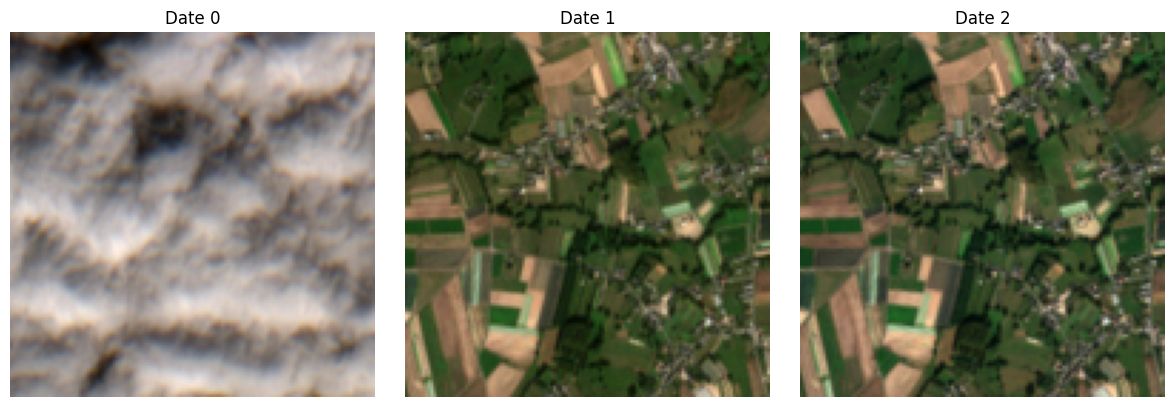

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 📂 Charger un fichier .npy (ex. tile_01.npy)
path = "/home/onyxia/work/utae-paps/S2_10001.npy"
data = np.load(path)  # shape = (T, C, H, W)

print(f"Shape : {data.shape}")  # Ex: (T, 10, H, W)

# 🔎 Vérifier le nombre de dates disponibles
T, C, H, W = data.shape

# 🖼️ Afficher quelques dates en RGB (bandes B4, B3, B2)
# Indices des bandes Sentinel-2 : B2=0, B3=1, B4=2, etc.
band_B4 = 2
band_B3 = 1
band_B2 = 0

# 🔄 Afficher par exemple les 3 premières dates
n_samples = min(3, T)
plt.figure(figsize=(12, 4))

for i in range(n_samples):
    rgb = np.stack([
        data[i, band_B4],  # Red
        data[i, band_B3],  # Green
        data[i, band_B2],  # Blue
    ], axis=-1)

    # 🔧 Normalisation pour l'affichage (entre 0 et 1)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)

    plt.subplot(1, n_samples, i + 1)
    plt.imshow(rgb)
    plt.title(f"Date {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()